In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# activate R magic
%load_ext rpy2.ipython

# python libs
from google.colab import drive
#drive.mount('/content/drive')
from drive.MyDrive.SSA.utils import *


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
from tqdm import tqdm
from pylab import rcParams
from matplotlib import rc
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr

import torch
from torch import nn, optim
from torch.autograd import Variable 
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from copy import copy, deepcopy

from scipy.stats import ttest_rel

import seaborn as sns
import statsmodels.api as sm

#from r_functions import create, run

# some settings
%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize'] = 14, 10

RANDOM_SEED = 15
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
!pip install skorch

In [ ]:
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, Checkpoint
from skorch.helper import predefined_split
from skorch.dataset import Dataset

In [ ]:
rpy2.robjects.numpy2ri.activate()
utils = importr('utils')
utils.chooseCRANmirror(ind=1)

#utils.install_packages('Rssa') # Rssa install;
rssa = importr('Rssa')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Models

In [ ]:
class FCModel(nn.Module):

  def __init__(self, input_size, hidden_size, output_size):
    super(FCModel, self).__init__()
    self.linear1 = torch.nn.Linear(input_size, hidden_size)
    self.linear2 = torch.nn.Linear(hidden_size, output_size)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.sigmoid1 = nn.Sigmoid()


  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)    
    out = x

    return out

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 36, output_size=1):
        super(LSTM, self).__init__()
        self.dummy_param = nn.Parameter(torch.empty(0))

        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        #self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True) #lstm
        self.relu = nn.ReLU()
        self.fc_1 = nn.Linear(hidden_size, output_size) #fully connected 1 #fully connected last layer
    
    def forward(self, x):
        device = self.dummy_param.device
        
        h_0  = Variable(torch.zeros(1, x.size(0), self.hidden_size)).to(device) #hidden state
        c_0 = Variable(torch.zeros(1, x.size(0), self.hidden_size)).to(device) #internal state
        # Propagate input through LSTM
        x = x.view(len(x), -1, 1)
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        out = hn
        #out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        
        return out.reshape(-1, 1)

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 36, output_size=1):
        super(GRU, self).__init__()
        self.dummy_param = nn.Parameter(torch.empty(0))

        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        #self.seq_length = seq_length #sequence length

        self.gru = nn.GRU(input_size, hidden_size, batch_first = True) #lstm
        self.relu = nn.ReLU()
        self.fc_1 = nn.Linear(hidden_size, output_size) #fully connected 1 #fully connected last layer
    
    def forward(self, x):
        device = self.dummy_param.device
        
        h_0  = Variable(torch.zeros(1, x.size(0), self.hidden_size)).to(device) #hidden state #internal state
        # Propagate input through LSTM
        x = x.view(len(x), -1, 1)
        output, hn = self.gru(x, h_0) #lstm with input, hidden, and internal state
        out = hn
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        
        return out.reshape(-1, 1)

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 36, output_size=1):
        super(RNN, self).__init__()
        self.dummy_param = nn.Parameter(torch.empty(0))

        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        #self.seq_length = seq_length #sequence length

        self.rnn = nn.RNN(input_size, hidden_size, batch_first = True, nonlinearity  = 'relu') #lstm
        self.relu = nn.ReLU()
        self.fc_1 = nn.Linear(hidden_size, output_size)#nn.Linear(hidden_size, output_size) #fully connected 1 #fully connected last layer
    
    def forward(self, x):
        device = self.dummy_param.device
        
        h_0  = Variable(torch.zeros(1, x.size(0), self.hidden_size)).to(device) #hidden state #internal state
        # Propagate input through LSTM
        x = x.view(len(x), -1, 1)
        output, hn = self.rnn(x, h_0) #lstm with input, hidden, and internal state
        out = hn
        #out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        
        return out.reshape(-1, 1)

In [ ]:
def getRMSE(y, y_pred, **kwargs):
  return np.sqrt(np.mean((y - y_pred)**2))

In [ ]:
def getStat(lPreds, ground_truth):
  res = np.zeros(len(lPreds)*len(lPreds)).reshape(len(lPreds), len(lPreds))
  for i in range(len(lPreds)):
    for k in range(i+1, len(lPreds)):
      _, pv = ttest_rel((lPreds[i]-lPreds[i])**2,(lPreds[k]-lPreds[i])**2)
      res[i, k] = res[k, i] = pv
  
  return pd.DataFrame(res)

In [ ]:
class MyEarlyStopping(EarlyStopping):
    def __init__(self,
            monitor='valid_loss',
            patience=5,
            threshold=1e-4,
            threshold_mode='rel',
            lower_is_better=True,
            sink=print,
    ):
      super().__init__(monitor, patience, threshold, threshold_mode, lower_is_better, sink)
      self.best_model_params_ = None

    def on_epoch_end(self, net, **kwargs):
        current_score = net.history[-1, self.monitor]
        if not self._is_score_improved(current_score):
            self.misses_ += 1
        else:
            self.misses_ = 0
            self.dynamic_threshold_ = self._calc_new_threshold(current_score)
            self.best_model_params_ = deepcopy(net.module_.state_dict())

        if self.misses_ == self.patience:
            net.module_.load_state_dict(self.best_model_params_)
            if net.verbose:
                self._sink("Stopping since {} has not improved in the last "
                           "{} epochs.".format(self.monitor, self.patience),
                           verbose=net.verbose)
            raise KeyboardInterrupt

# Incorrect


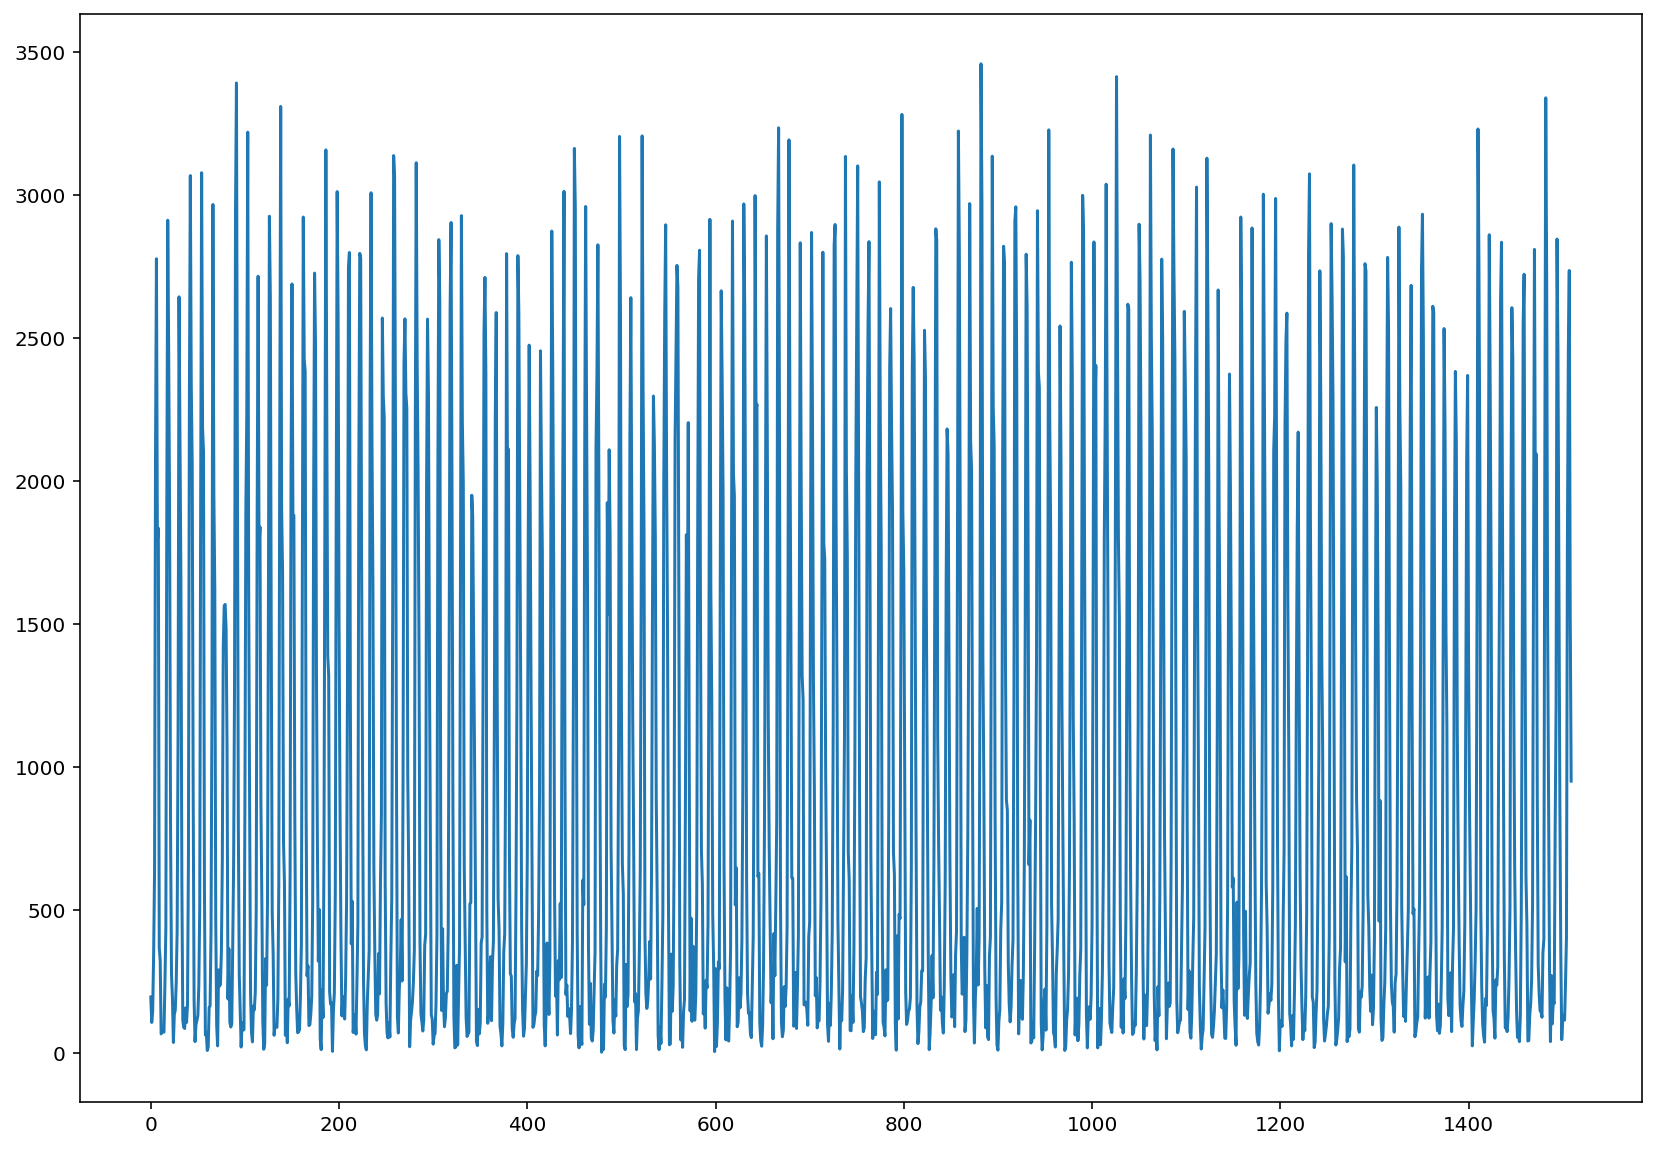

In [ ]:
filepath = "drive/MyDrive/SSA/rain_m.txt"

rain_df = pd.read_csv(filepath, sep = '\t', header=None)
rain = []
for i in range(146):
  rain = rain + [m for m in rain_df.iloc[i]] 

SIZE = 1510;
rain_m = np.array(rain[:SIZE])
plt.plot(rain_m);

In [ ]:
np.sqrt((tsSin_sig**2).mean() / 0.5)

9.519554899822513

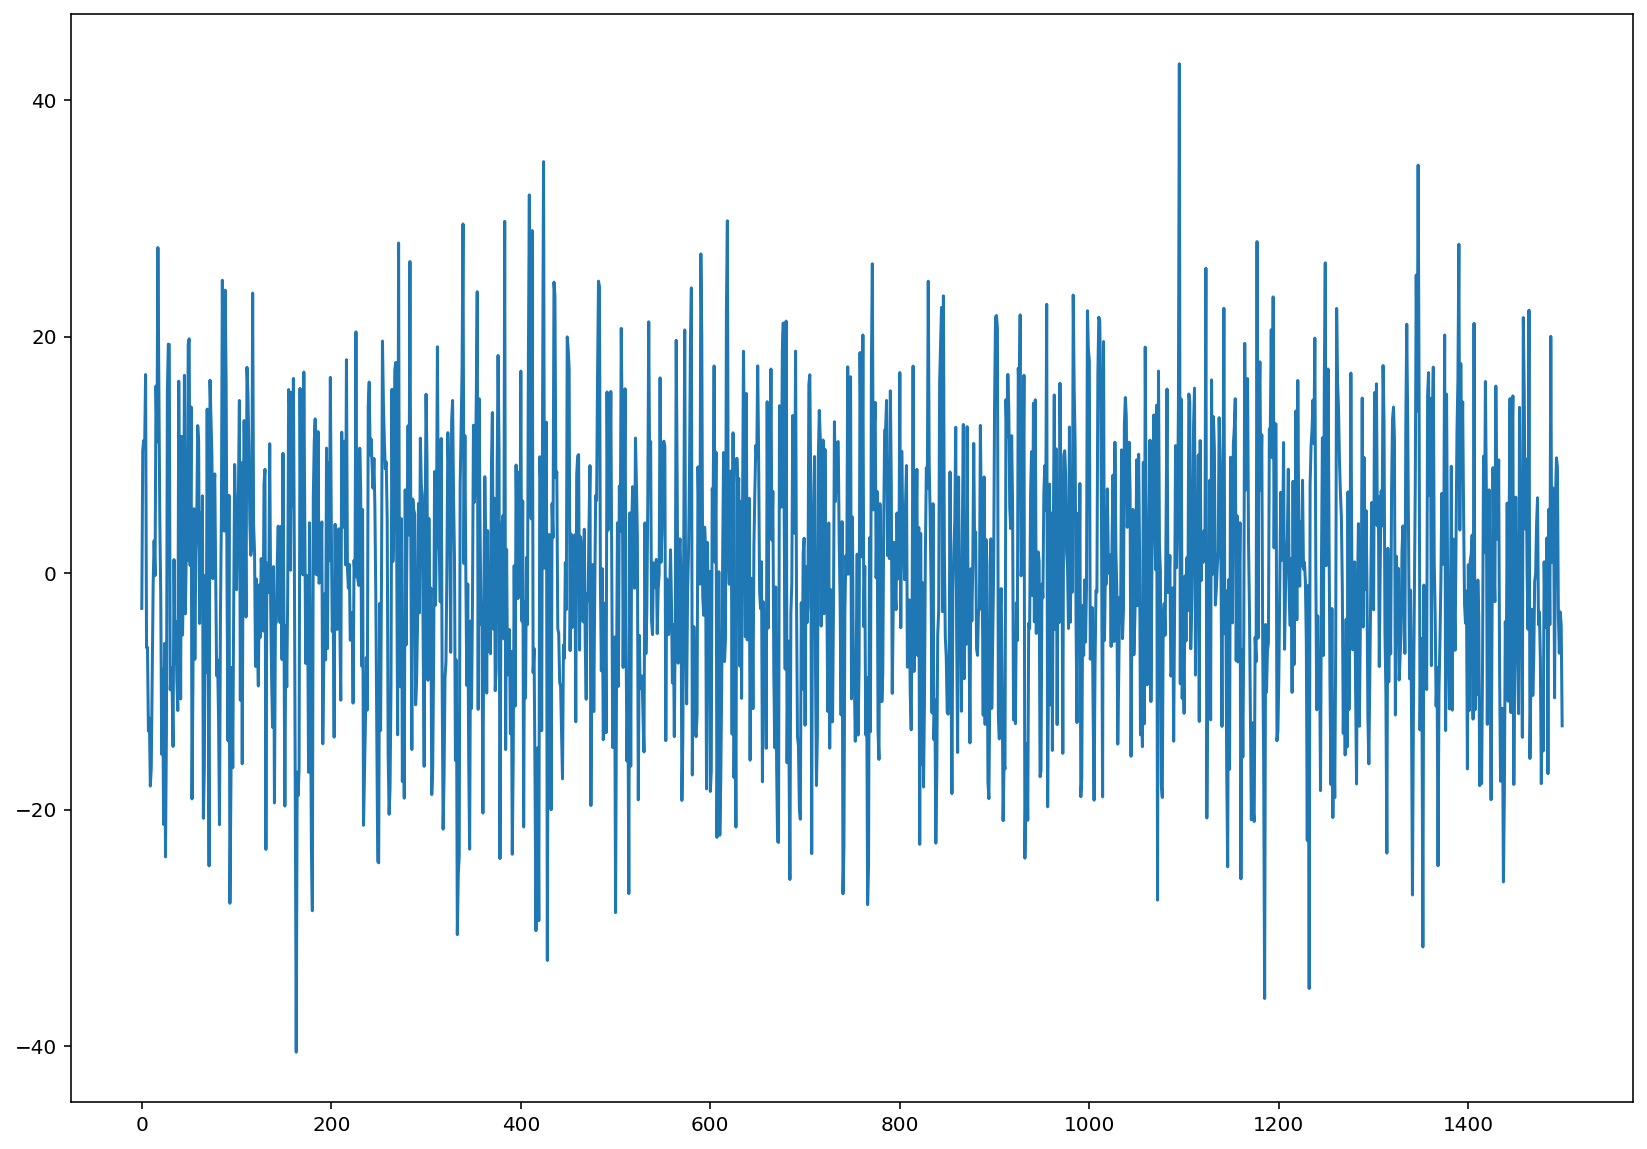

In [ ]:
# sin
SIZE = 1500;
np.random.seed(RANDOM_SEED)
T = 12

#tsSin_sig = np.sin(np.arange(SIZE) * 2 * np.pi / T)
tsSin_sig = (np.sin(np.arange(SIZE) * 2 * np.pi / T) + 1.6 * np.sin(np.arange(SIZE) * 2 * np.pi / (T+2))) * (\
np.cos(np.arange(SIZE) * 2 * np.pi / (144*3)) + 5)

tsSin = tsSin_sig + np.sqrt((tsSin_sig**2).mean() / 0.5) * np.random.normal(size=SIZE)
plt.plot(tsSin);

In [ ]:
list(range(1,2))

[1]

In [ ]:
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 1000, 500, 10;
seq_len = 24;

assert TRAIN_SIZE + VAL_SIZE + TEST_SIZE == SIZE, "wrong TRAIN and VAL sizes"

ssa = edict({
    'L' : TRAIN_SIZE//2,
    'ssa_groups' : list(range(1,8)), #[1,2,3,4,5,6,7],
    'rssa' : rssa
})

# split_data
data = splitData(rain_m, seq_len, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa, val_ssa = True)
#data_sig = splitData(tsSin_sig, seq_len, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa, val_ssa = False)

100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


In [ ]:
len(rain_m[:-10])

1500

In [ ]:
data_test = splitData(rain_m[:-10], seq_len, 990, 10, 500, ssa, val_ssa = True)

0it [00:00, ?it/s]
100%|██████████| 500/500 [05:40<00:00,  1.47it/s]


In [ ]:
train_ds = Dataset(data.train.X, data.train.y.reshape(-1, 1))

valid_ds = Dataset(data.val.X, data.val.y.reshape(-1, 1))
valid_ds_ssa = Dataset(data.val.X_ssa, data.val.y.reshape(-1, 1))

In [ ]:
# sine
#ann_hidden = 100
#rnn_hidden = 65
#gru_hidden = 100
#lstm_hidden = 55

# dsine
#ann_hidden = 55
#rnn_hidden = 70
#gru_hidden = 100
#lstm_hidden = 80

# india_rain
ann_hidden = 60
rnn_hidden = 90
gru_hidden = 65
lstm_hidden = 95

## Fully Connected

In [ ]:
fcnet = NeuralNetRegressor(  FCModel
                         , module__input_size=24
                         , module__hidden_size=ann_hidden
                         , module__output_size=1
                           
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience = 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

fcnet_ssa = NeuralNetRegressor(  FCModel
                         , module__input_size=24
                         , module__hidden_size=ann_hidden
                         , module__output_size=1       
                        
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet.fit(data.train.X, data.train.y.reshape(-1, 1));
fcnet.history[-1]

{'batches': [{'train_batch_size': 976, 'train_loss': 0.0703197717666626},
  {'valid_batch_size': 226, 'valid_loss': 0.06712563335895538}],
 'dur': 0.014145135879516602,
 'epoch': 611,
 'train_batch_count': 1,
 'train_loss': 0.0703197717666626,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.06712563335895538,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet_ssa.fit(data.train.X_ssa, data.train.y.reshape(-1, 1));
fcnet_ssa.history[-1]

{'batches': [{'train_batch_size': 976, 'train_loss': 0.07083605229854584},
  {'valid_batch_size': 226, 'valid_loss': 0.06250783801078796}],
 'dur': 0.011909246444702148,
 'epoch': 533,
 'train_batch_count': 1,
 'train_loss': 0.07083605229854584,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.06250783801078796,
 'valid_loss_best': False}

## RNN

In [ ]:
rnnnet = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = rnn_hidden
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

rnnnet_ssa = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = rnn_hidden
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet.fit(data.train.X, data.train.y.reshape(-1, 1));
rnnnet.history[-1]

{'batches': [{'train_batch_size': 976, 'train_loss': 0.06974302232265472},
  {'valid_batch_size': 226, 'valid_loss': 0.06647493690252304}],
 'dur': 0.06289052963256836,
 'epoch': 160,
 'train_batch_count': 1,
 'train_loss': 0.06974302232265472,
 'train_loss_best': False,
 'valid_batch_count': 1,
 'valid_loss': 0.06647493690252304,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet_ssa.fit(data.train.X_ssa, data.train.y.reshape(-1, 1));
rnnnet_ssa.history[-1]

{'batches': [{'train_batch_size': 976, 'train_loss': 0.07202058285474777},
  {'valid_batch_size': 226, 'valid_loss': 0.066562220454216}],
 'dur': 0.060016632080078125,
 'epoch': 155,
 'train_batch_count': 1,
 'train_loss': 0.07202058285474777,
 'train_loss_best': False,
 'valid_batch_count': 1,
 'valid_loss': 0.066562220454216,
 'valid_loss_best': False}

## GRU

In [ ]:
grunet = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = gru_hidden
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

grunet_ssa = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = gru_hidden
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet.fit(data.train.X, data.train.y.reshape(-1, 1));
grunet.history[-1]

{'batches': [{'train_batch_size': 976, 'train_loss': 0.0697331354022026},
  {'valid_batch_size': 226, 'valid_loss': 0.06275386363267899}],
 'dur': 0.12862634658813477,
 'epoch': 414,
 'train_batch_count': 1,
 'train_loss': 0.0697331354022026,
 'train_loss_best': False,
 'valid_batch_count': 1,
 'valid_loss': 0.06275386363267899,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet_ssa.fit(data.train.X_ssa, data.train.y.reshape(-1, 1));
grunet_ssa.history[-1]

{'batches': [{'train_batch_size': 976, 'train_loss': 0.07183767855167389},
  {'valid_batch_size': 226, 'valid_loss': 0.08792394399642944}],
 'dur': 0.12439656257629395,
 'epoch': 156,
 'train_batch_count': 1,
 'train_loss': 0.07183767855167389,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.08792394399642944,
 'valid_loss_best': False}

## LSTM

In [ ]:
lstmnet = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = lstm_hidden
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

lstmnet_ssa = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = lstm_hidden
                         , module__output_size=1
                        # , module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet.fit(data.train.X, data.train.y.reshape(-1, 1));
lstmnet.history[-1]

{'batches': [{'train_batch_size': 976, 'train_loss': 0.07260837405920029},
  {'valid_batch_size': 226, 'valid_loss': 0.06207582727074623}],
 'dur': 0.2855713367462158,
 'epoch': 370,
 'train_batch_count': 1,
 'train_loss': 0.07260837405920029,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.06207582727074623,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet_ssa.fit(data.train.X_ssa, data.train.y.reshape(-1, 1));
lstmnet_ssa.history[-1]

{'batches': [{'train_batch_size': 976, 'train_loss': 0.07173985242843628},
  {'valid_batch_size': 226, 'valid_loss': 0.06100989133119583}],
 'dur': 0.28281641006469727,
 'epoch': 248,
 'train_batch_count': 1,
 'train_loss': 0.07173985242843628,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.06100989133119583,
 'valid_loss_best': False}

## Results

In [ ]:
pc_ann =  getPredCases(fcnet.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_ann =  getPredCases(fcnet_ssa.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = ssa)
#====================
pc_rnn =  getPredCases(rnnnet.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_rnn =  getPredCases(rnnnet_ssa.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = ssa)
#====================
pc_gru =  getPredCases(grunet.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_gru =  getPredCases(grunet_ssa.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = ssa)
#====================
pc_lstm =  getPredCases(lstmnet.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_lstm =  getPredCases(lstmnet_ssa.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = ssa)

100%|██████████| 250/250 [00:00<00:00, 557.33it/s]


In [ ]:
errs = {'ANN' : getRMSE(rain_m[-TEST_SIZE:], pc_ann)
        , 'SSA-ANN' : getRMSE(rain_m[-TEST_SIZE:], pc_ssa_ann)
        , 'RNN' : getRMSE(rain_m[-TEST_SIZE:], pc_rnn)
        , 'SSA-RNN' : getRMSE(rain_m[-TEST_SIZE:], pc_ssa_rnn)
        , 'GRU' : getRMSE(rain_m[-TEST_SIZE:], pc_gru)
        , 'SSA-GRU' : getRMSE(rain_m[-TEST_SIZE:], pc_ssa_gru)
        , 'LSTM' : getRMSE(rain_m[-TEST_SIZE:], pc_lstm)
        , 'SSA-LSTM' : getRMSE(rain_m[-TEST_SIZE:], pc_ssa_lstm)
        }
pd.DataFrame().from_dict(errs, orient='index').T

,ANN,SSA-ANN,RNN,SSA-RNN,GRU,SSA-GRU,LSTM,SSA-LSTM
0,223.540602,219.889018,220.378617,223.014074,224.508065,219.102821,229.615421,217.187251


In [ ]:
errs = {'ANN' : getRMSE(tsSin_sig[-TEST_SIZE:], pc_ann)
        , 'SSA-ANN' : getRMSE(tsSin_sig[-TEST_SIZE:], pc_ssa_ann)
        , 'RNN' : getRMSE(tsSin_sig[-TEST_SIZE:], pc_rnn)
        , 'SSA-RNN' : getRMSE(tsSin_sig[-TEST_SIZE:], pc_ssa_rnn)
        , 'GRU' : getRMSE(tsSin_sig[-TEST_SIZE:], pc_gru)
        , 'SSA-GRU' : getRMSE(tsSin_sig[-TEST_SIZE:], pc_ssa_gru)
        , 'LSTM' : getRMSE(tsSin_sig[-TEST_SIZE:], pc_lstm)
        , 'SSA-LSTM' : getRMSE(tsSin_sig[-TEST_SIZE:], pc_ssa_lstm)
        }
pd.DataFrame().from_dict(errs, orient='index').T

,ANN,SSA-ANN,RNN,SSA-RNN,GRU,SSA-GRU,LSTM,SSA-LSTM
0,0.356541,0.738724,0.293228,0.493166,0.282055,0.417707,0.272393,0.353813


sine 24, L = половина, r = 1:

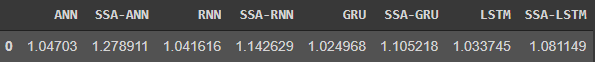

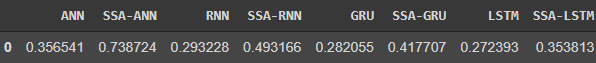

sine 24, L = половина, r = 2:

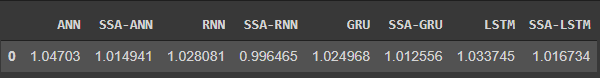

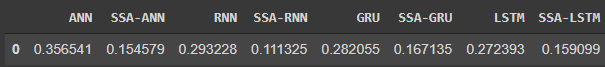

sine 24, L = половина, r = 4:

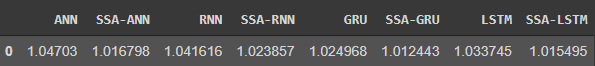

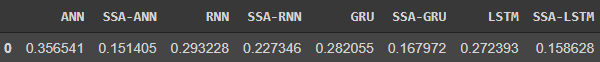

dsine 26, L = 130, r = 4:

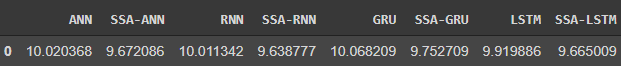

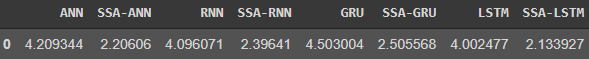

dsine 26, L = 130, r = 8:

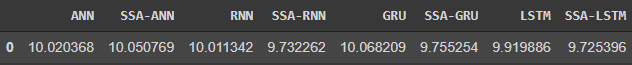

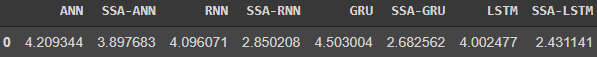

dsine 26, L = 130, r = 12:

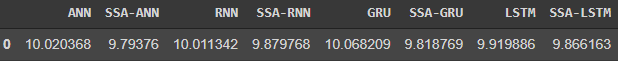

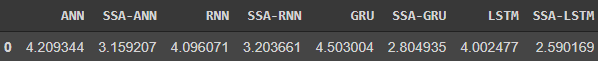

dsine 26, L = 130, r = 16:

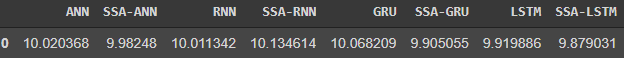

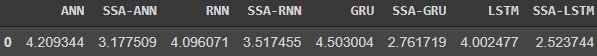


dsine 26, L = половина, r = 4:

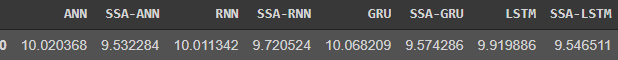

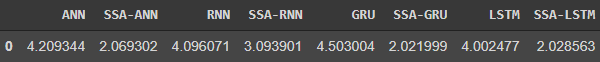

dsine 26, L = половина, r = 8:

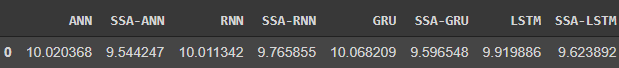

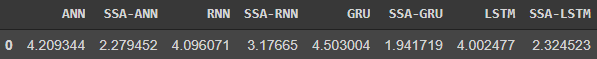

dsine 26, L = половина, r = 12:

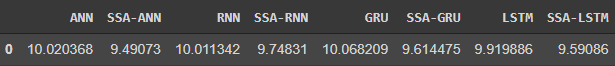

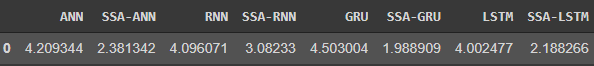

dsine 26, L = половина, r = 16:

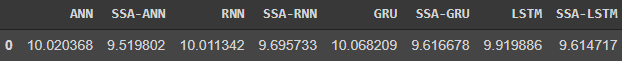

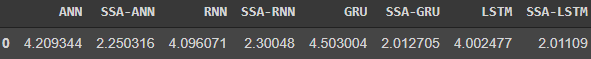

indian_rain 24, L = половина, r = 5:

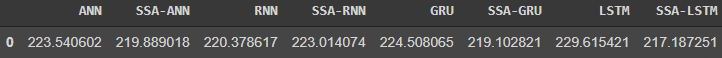

indian_rain 24, L = половина, r = 7:

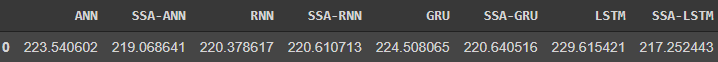

indian_rain 24, L = половина, r = 9:

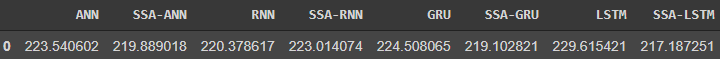

In [ ]:
def saveStats(lPreds, ground_truth, columns = None):
    res = np.zeros(16*250).reshape(-1, 250)
    for i in range(0, len(lPreds)):
        res[2*i] = lPreds[i]
        res[2*i+1] = (lPreds[i] - ground_truth)**2
    res_df = pd.DataFrame(res.T)
    if columns is not None:
      res_df.columns = columns;
    res_df.to_csv("file.csv")
    return res_df

## GridSearchCV for LSTM

In [ ]:
data.scaler.var_[0]

917441.984711

In [ ]:
def customGridSearch(params, train_ds, val_ds, RANDOM_SEED):
  lResultsSeries = []
  lResultsSignal = []
  best_score = 100000
  best_param = None

  for param in params:
    lstmnet = NeuralNetRegressor( GRU
                         , module__input_size = 1
                         , module__hidden_size = param
                         , module__output_size = 1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience = 50) 
                         ]
                         , train_split= predefined_split(val_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device
                         , criterion = torch.nn.modules.loss.MSELoss
                         #, optimizer__weight_decay=0.01
                         )
    
    torch.manual_seed(RANDOM_SEED)
    lstmnet.fit(train_ds[0], train_ds[1])
    #pc =  getPredCases(lstmnet.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = None)
  
    #preds = getPredsTomorrow(
    #      lstmnet.module_.to('cpu')
    #    , data.ts[:TRAIN_SIZE][-data.seq_len:]
    #    , data.ts[TRAIN_SIZE : (TRAIN_SIZE+VAL_SIZE)] 
    #    , data.scaler
    #    , VAL_SIZE
    #    , data.seq_len
    #    )
    
    seq = applySSA(data.ts[:data.train.size], ssa)
    seq = seq[-data.seq_len:]
    preds = getPredsTomorrow(
          lstmnet.module_.to('cpu')
        , seq
        , data_test.test.ts_ssa
        , data.scaler_ssa
        , VAL_SIZE
        , data.seq_len
        )
    
    pc = data.scaler.inverse_transform(
        np.expand_dims(preds, axis=0)
        ).flatten()

    

    print(
          "Param:", param
          , "; Loss series:", getRMSE(rain_m[TRAIN_SIZE:(TRAIN_SIZE+VAL_SIZE)], pc)
          #, "; Loss signal:", getRMSE(tsSin_sig[TRAIN_SIZE:(TRAIN_SIZE+VAL_SIZE)], pc)
          ) 

    if (best_score > lstmnet.history[-1]['valid_loss']):
        best_score = lstmnet.history[-1]['valid_loss']
        best_param = param

    lResultsSeries.append( getRMSE(rain_m[TRAIN_SIZE:(TRAIN_SIZE+VAL_SIZE)], pc) )
    #lResultsSignal.append( getRMSE(tsSin_sig[TRAIN_SIZE:(TRAIN_SIZE+VAL_SIZE)], pc) )

  return best_param, (lResultsSeries, lResultsSignal)

In [ ]:
 _, lRNN = customGridSearch(list(range(10, 101, 5)), (data.train.X_ssa, data.train.y.reshape(-1, 1)), valid_ds_ssa, RANDOM_SEED = RANDOM_SEED)

100%|██████████| 500/500 [00:00<00:00, 564.21it/s]


Param: 10 ; Loss series: 231.62125948506363


100%|██████████| 500/500 [00:00<00:00, 581.43it/s]


Param: 15 ; Loss series: 231.77128056319174


100%|██████████| 500/500 [00:00<00:00, 560.39it/s]


Param: 20 ; Loss series: 230.65769438116502


100%|██████████| 500/500 [00:00<00:00, 558.54it/s]


Param: 25 ; Loss series: 232.7477142472355


100%|██████████| 500/500 [00:00<00:00, 560.96it/s]


Param: 30 ; Loss series: 231.46992114805914


100%|██████████| 500/500 [00:00<00:00, 548.08it/s]


Param: 35 ; Loss series: 231.35682306056168


100%|██████████| 500/500 [00:00<00:00, 564.18it/s]


Param: 40 ; Loss series: 230.63886600552058


100%|██████████| 500/500 [00:00<00:00, 537.20it/s]


Param: 45 ; Loss series: 230.63836797276727


100%|██████████| 500/500 [00:00<00:00, 541.91it/s]


Param: 50 ; Loss series: 230.86266857703006


100%|██████████| 500/500 [00:00<00:00, 547.04it/s]


Param: 55 ; Loss series: 230.31158090672585


100%|██████████| 500/500 [00:00<00:00, 527.39it/s]


Param: 60 ; Loss series: 231.8270384178784


100%|██████████| 500/500 [00:00<00:00, 547.82it/s]


Param: 65 ; Loss series: 231.50017727356072


100%|██████████| 500/500 [00:00<00:00, 539.57it/s]


Param: 70 ; Loss series: 230.41096520389576


100%|██████████| 500/500 [00:01<00:00, 494.00it/s]


Param: 75 ; Loss series: 230.53091662501748


100%|██████████| 500/500 [00:00<00:00, 518.78it/s]


Param: 80 ; Loss series: 229.58978411285872


100%|██████████| 500/500 [00:00<00:00, 539.15it/s]


Param: 85 ; Loss series: 230.88413060146394


100%|██████████| 500/500 [00:00<00:00, 521.79it/s]


Param: 90 ; Loss series: 230.42226563172838


100%|██████████| 500/500 [00:00<00:00, 523.82it/s]


Param: 95 ; Loss series: 230.6508746194117


100%|██████████| 500/500 [00:00<00:00, 522.83it/s]

Param: 100 ; Loss series: 230.6614241045149


In [ ]:
folder = 'indian_rain'
name = 'gru'

with open(f'drive/MyDrive/SSA/{folder}/{str(seq_len)}/{name}_ssa_series.txt', 'w') as f:
    for item in lRNN[0]:
        f.write("%s\n" % item)

with open(f'drive/MyDrive/SSA/{folder}/{str(seq_len)}/{name}_ssa_signal.txt', 'w') as f:
    for item in lRNN[1]:
        f.write("%s\n" % item)

0.011824857649826296


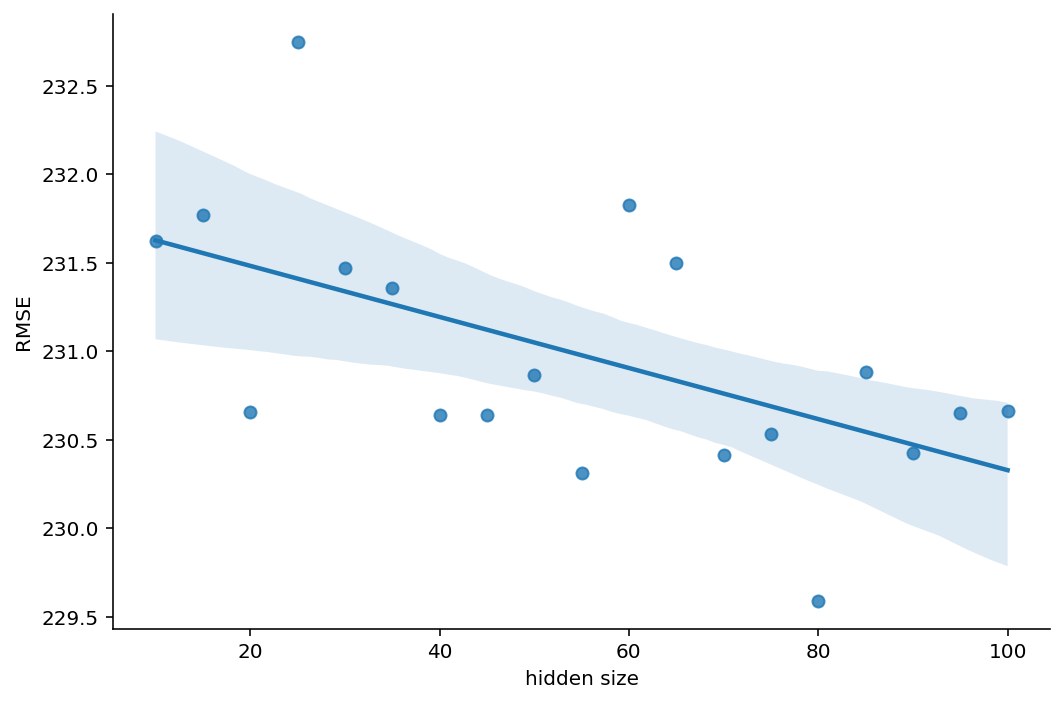

In [ ]:
folder = 'indian_rain'
seq_len = 24
name = 'gru'

x_axis = list(range(10, 101, 5))

l1 = np.loadtxt(f'drive/MyDrive/SSA/{folder}/{str(seq_len)}/{name}_ssa_series.txt')
#l2 = np.loadtxt(f'drive/MyDrive/SSA/{folder}/{str(seq_len)}/{name}_signal.txt')

sns.lmplot(x="hidden size", y="RMSE", data=pd.DataFrame(np.array([x_axis, l1]).T, columns=['hidden size','RMSE']), height=5, aspect=1.5);
#sns.lmplot(x="hidden size", y="RMSE", data=pd.DataFrame(np.array([x_axis, l2]).T, columns=['hidden size','RMSE']), height=5, aspect=1.5);

X2 = sm.add_constant(x_axis)
est = sm.OLS(l1, X2)
est2 = est.fit()

print(est2.pvalues[1])

#est = sm.OLS(l2, X2)
#est2 = est.fit()

#print(est2.pvalues[1])

NameError: ignored

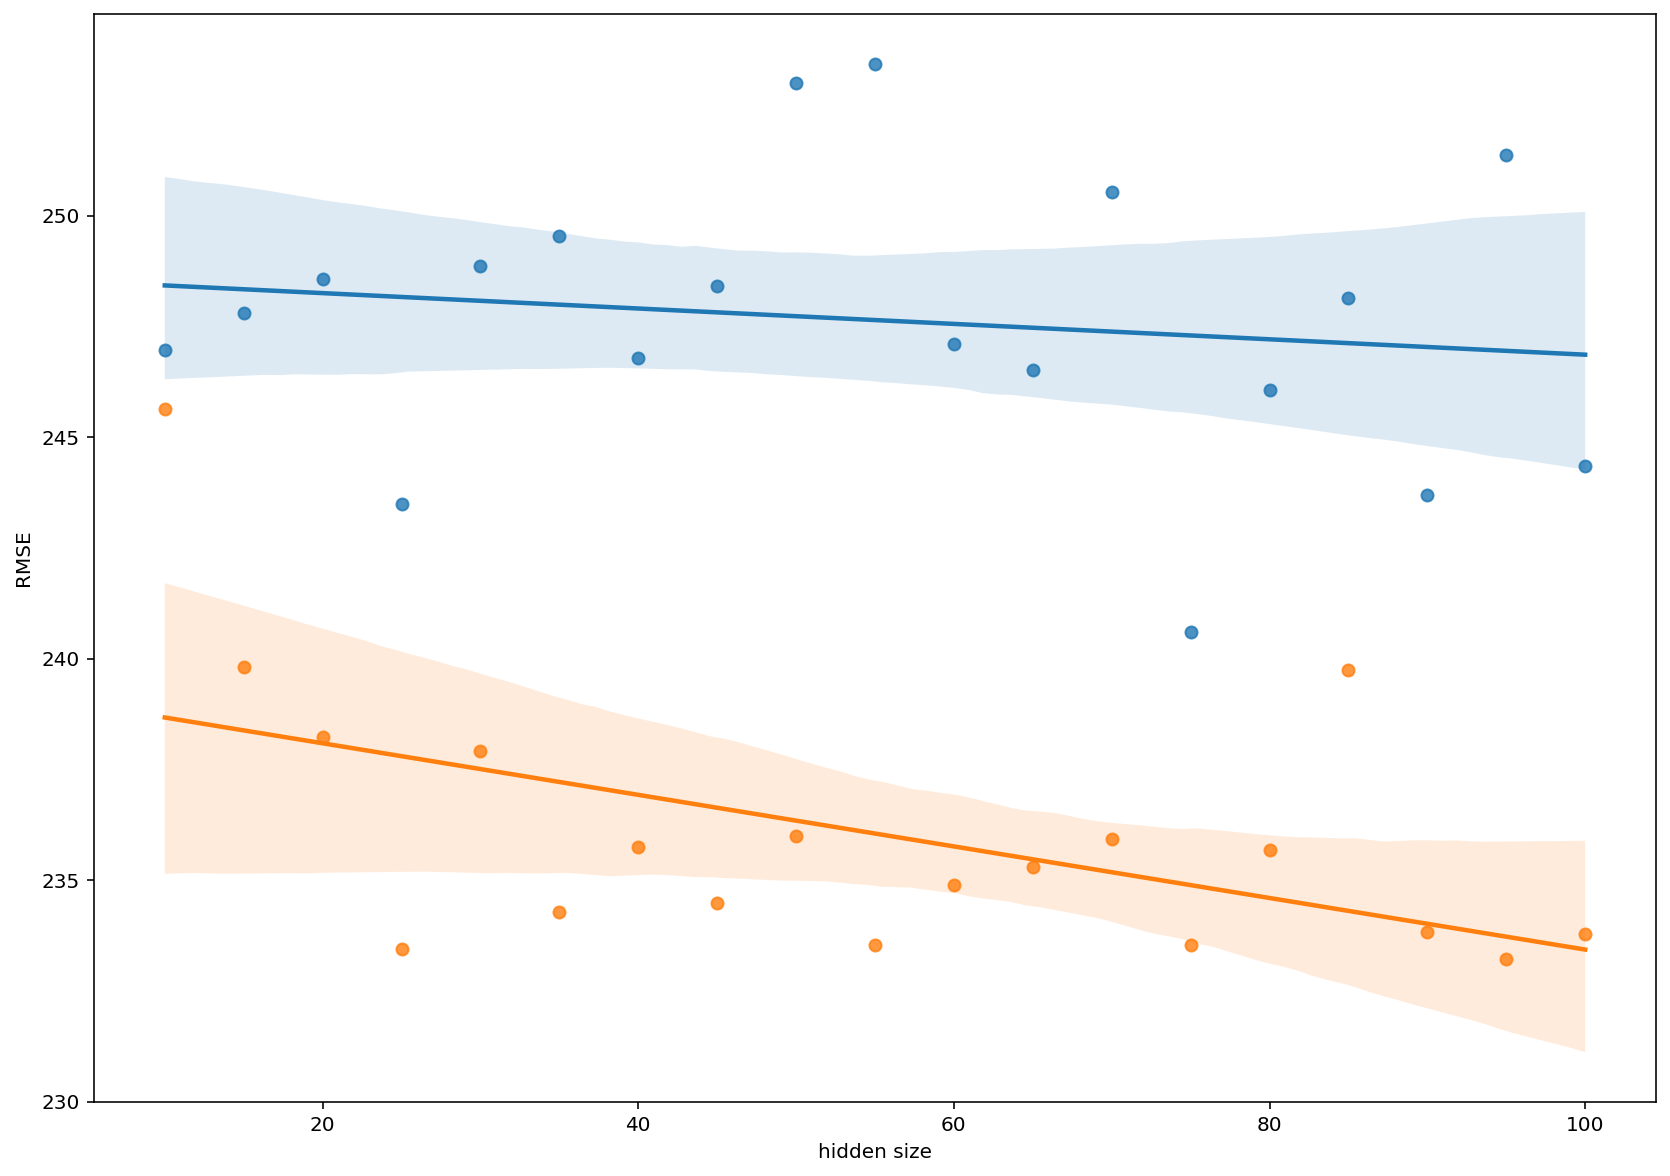

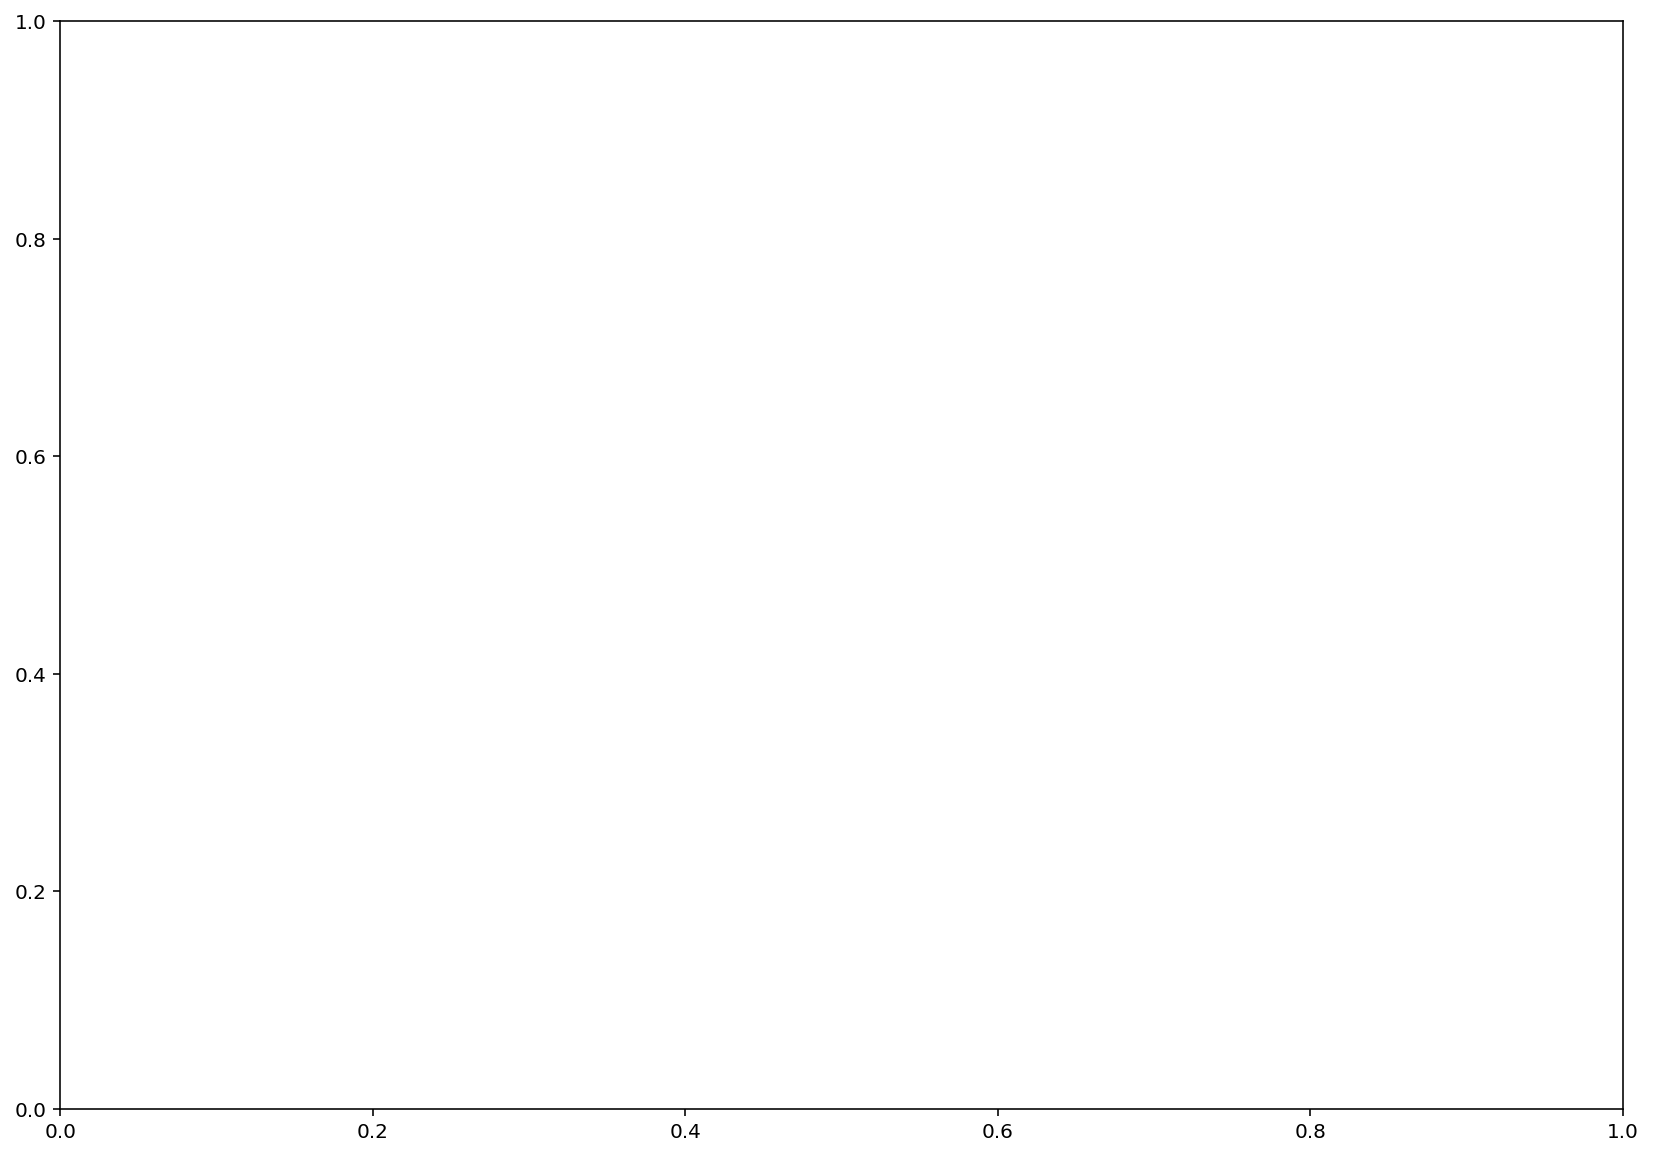

In [ ]:
folder = 'indian_rain'

name = 'gru'

x_axis = list(range(10, 101, 5))

l11 = np.loadtxt(f'drive/MyDrive/SSA/{folder}/12/{name}_series.txt')
l12 = np.loadtxt(f'drive/MyDrive/SSA/{folder}/24/{name}_series.txt')
#l21 = np.loadtxt(f'drive/MyDrive/SSA/{folder}/13/{name}_signal.txt')
#l22 = np.loadtxt(f'drive/MyDrive/SSA/{folder}/26/{name}_signal.txt')

fig, ax = plt.subplots()

sns.regplot(x="hidden size", y="RMSE", 
           data=pd.DataFrame(np.array([x_axis, l11]).T, columns=['hidden size','RMSE'])
           , ax = ax);
sns.regplot(x="hidden size", y="RMSE", 
           data=pd.DataFrame(np.array([x_axis, l12]).T, columns=['hidden size','RMSE'])
          , ax = ax);


fig, ax = plt.subplots()

sns.regplot(x="hidden size", y="RMSE", 
           data=pd.DataFrame(np.array([x_axis, l21]).T, columns=['hidden size','RMSE'])
           , ax = ax);
sns.regplot(x="hidden size", y="RMSE", 
           data=pd.DataFrame(np.array([x_axis, l22]).T, columns=['hidden size','RMSE'])
          , ax = ax);

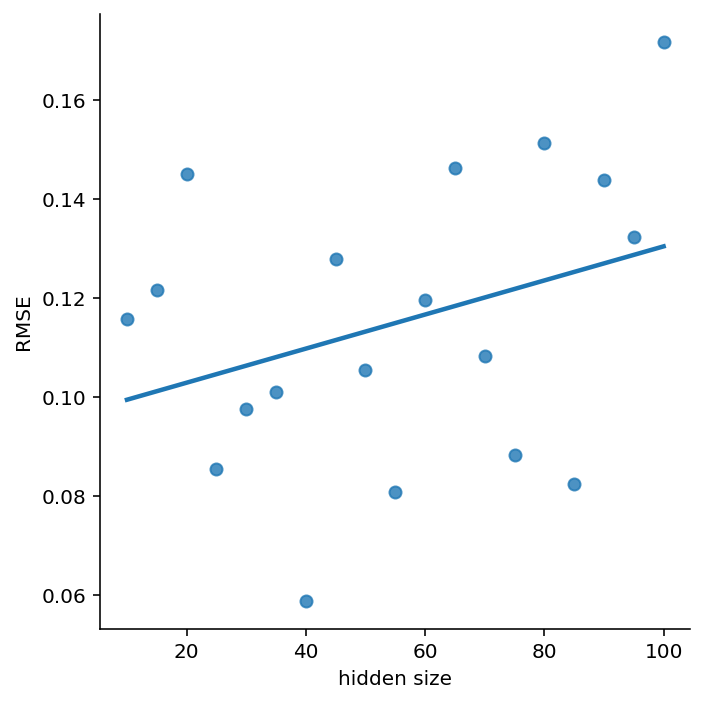

In [ ]:
sns.lmplot(x="hidden size", y="RMSE", data=pd.DataFrame(np.array([list(range(10, 101, 5)), lANN]).T, columns=['hidden size','RMSE']), ci=None);

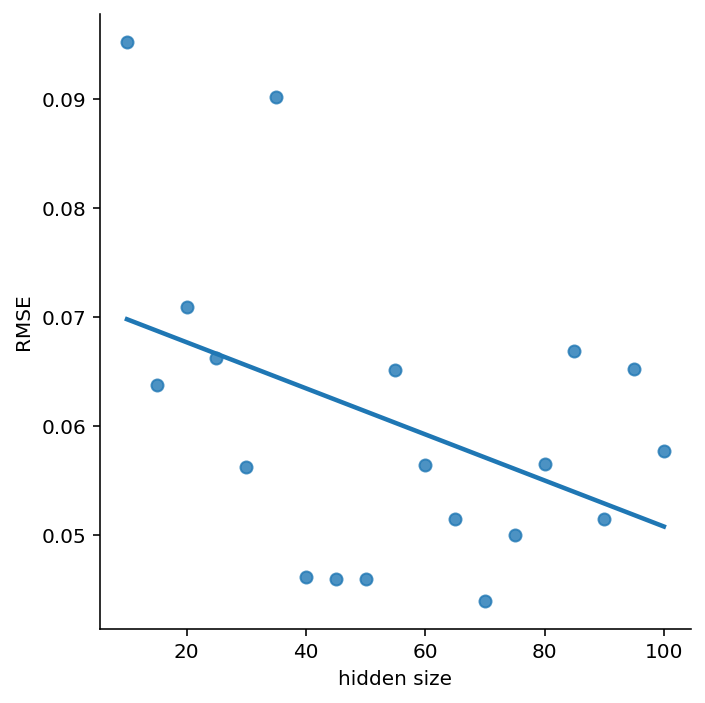

In [ ]:
sns.lmplot(x="hidden size", y="RMSE", data=pd.DataFrame(np.array([list(range(10, 101, 5)), lRNN]).T, columns=['hidden size','RMSE']), ci=None);

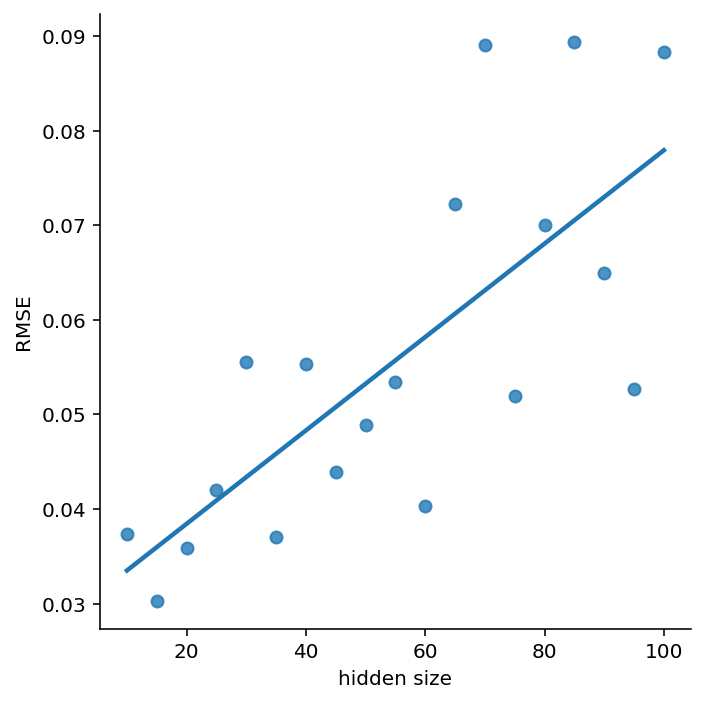

In [ ]:
sns.lmplot(x="hidden size", y="RMSE", data=pd.DataFrame(np.array([list(range(10, 101, 5)), lLSTM]).T, columns=['hidden size','RMSE']), ci=None);

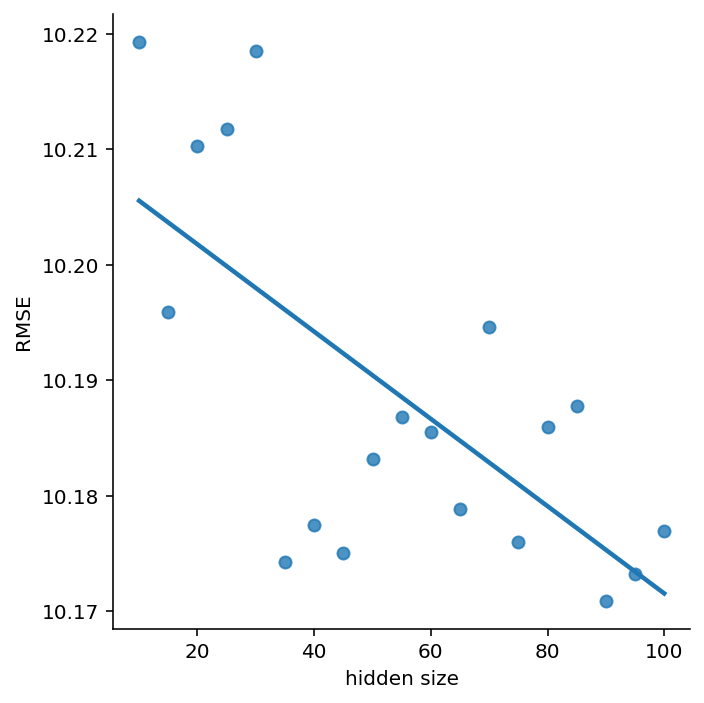

In [ ]:
sns.lmplot(x="hidden size", y="RMSE", data=pd.DataFrame(np.array([list(range(10, 101, 5)), lGRU]).T, columns=['hidden size','RMSE']), ci=None);

In [ ]:
res = np.zeros(len(list(range(10, 101, 5))))

for i in range(10):
  _, lANN = customGridSearch(list(range(10, 101, 5)), (data.train.X, data.train.y.reshape(-1, 1)), valid_ds, RANDOM_SEED = RANDOM_SEED + i)
  res += np.array(lRNN)

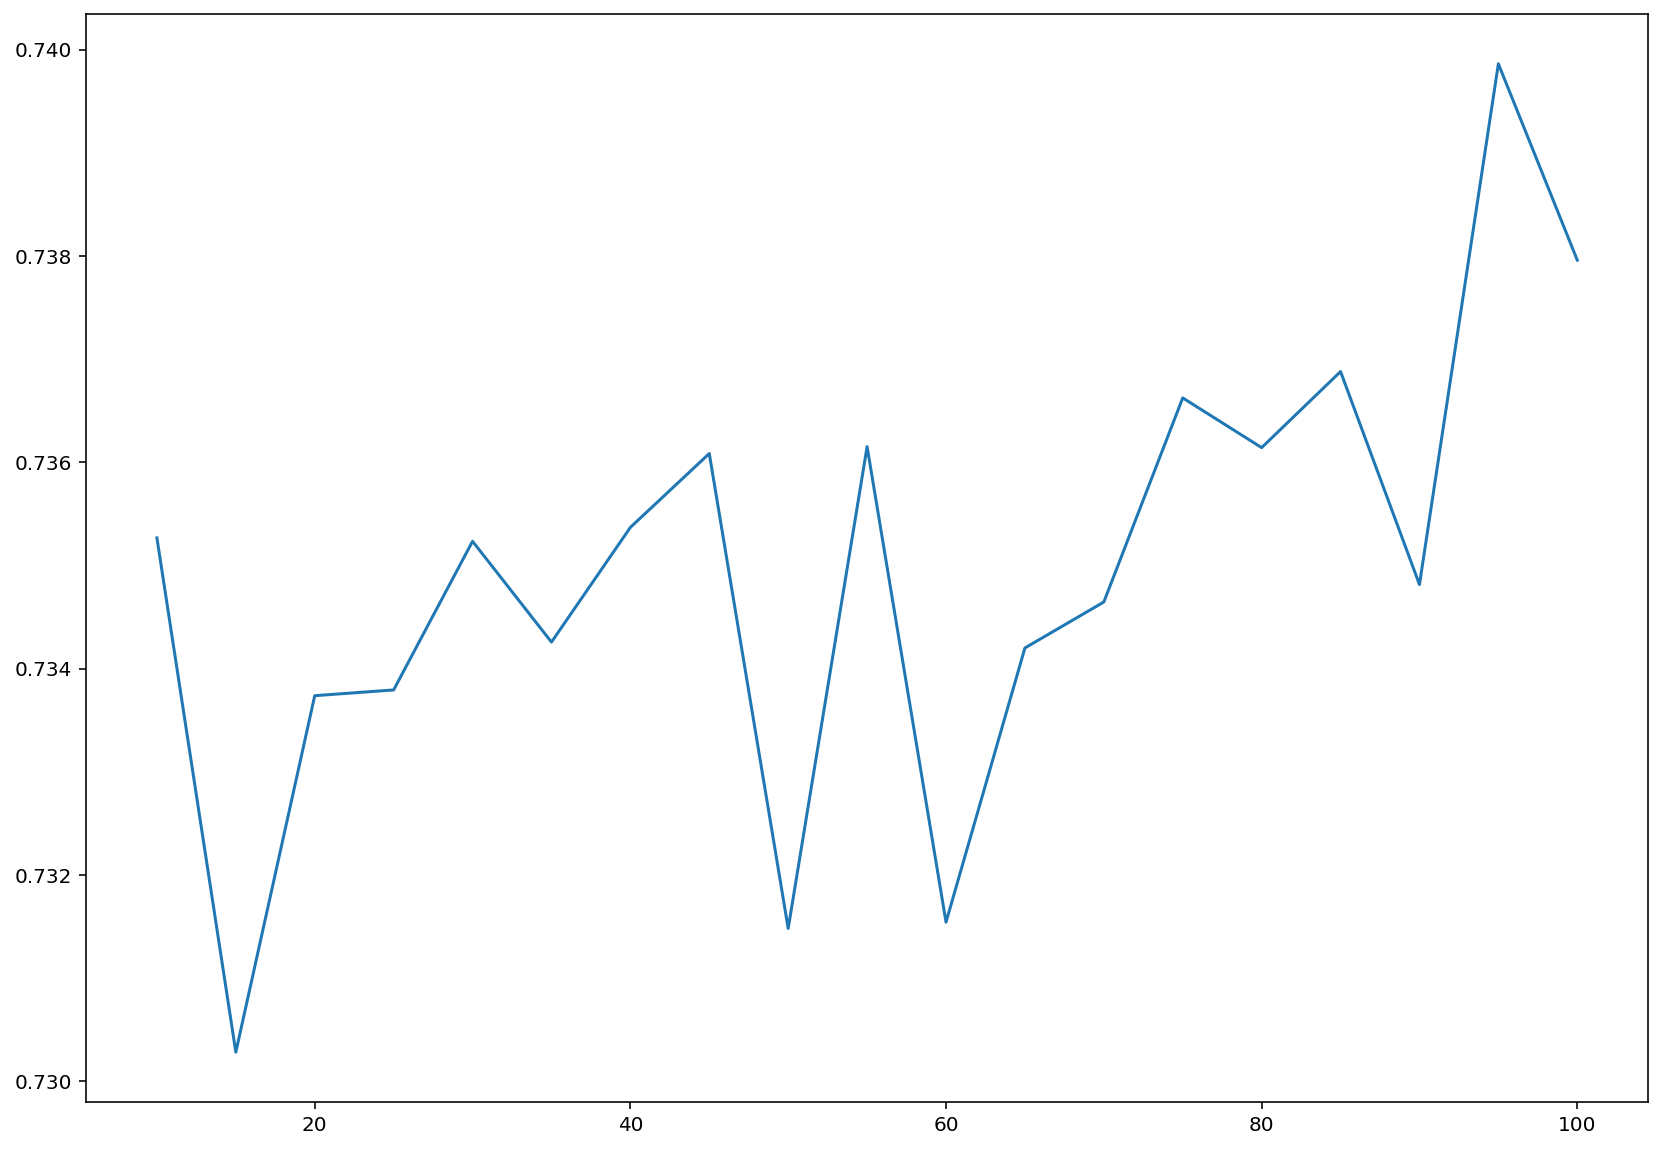

In [ ]:
plt.plot(list(range(10, 101, 5)), res / 10)

In [ ]:
_, lRNN = customGridSearch(list(range(10, 101, 5)), (data.train.X, data.train.y.reshape(-1, 1)), valid_ds, RANDOM_SEED = RANDOM_SEED)

Param:  10 ; Loss:  0.7530879378318787
Param:  15 ; Loss:  0.734074592590332
Param:  20 ; Loss:  0.745476245880127
Param:  25 ; Loss:  0.7492629885673523
Param:  30 ; Loss:  0.7505567073822021
Param:  35 ; Loss:  0.7414951920509338
Param:  40 ; Loss:  0.7702997326850891
Param:  45 ; Loss:  0.7545102834701538
Param:  50 ; Loss:  0.7598825693130493
Param:  55 ; Loss:  0.7432661056518555
Param:  60 ; Loss:  0.7363592982292175
Param:  65 ; Loss:  0.7478481531143188
Param:  70 ; Loss:  0.7500174641609192
Param:  75 ; Loss:  0.7534358501434326
Param:  80 ; Loss:  0.746361494064331
Param:  85 ; Loss:  0.7452532052993774
Param:  90 ; Loss:  0.758103609085083
Param:  95 ; Loss:  0.7615625858306885
Param:  100 ; Loss:  0.76808762550354


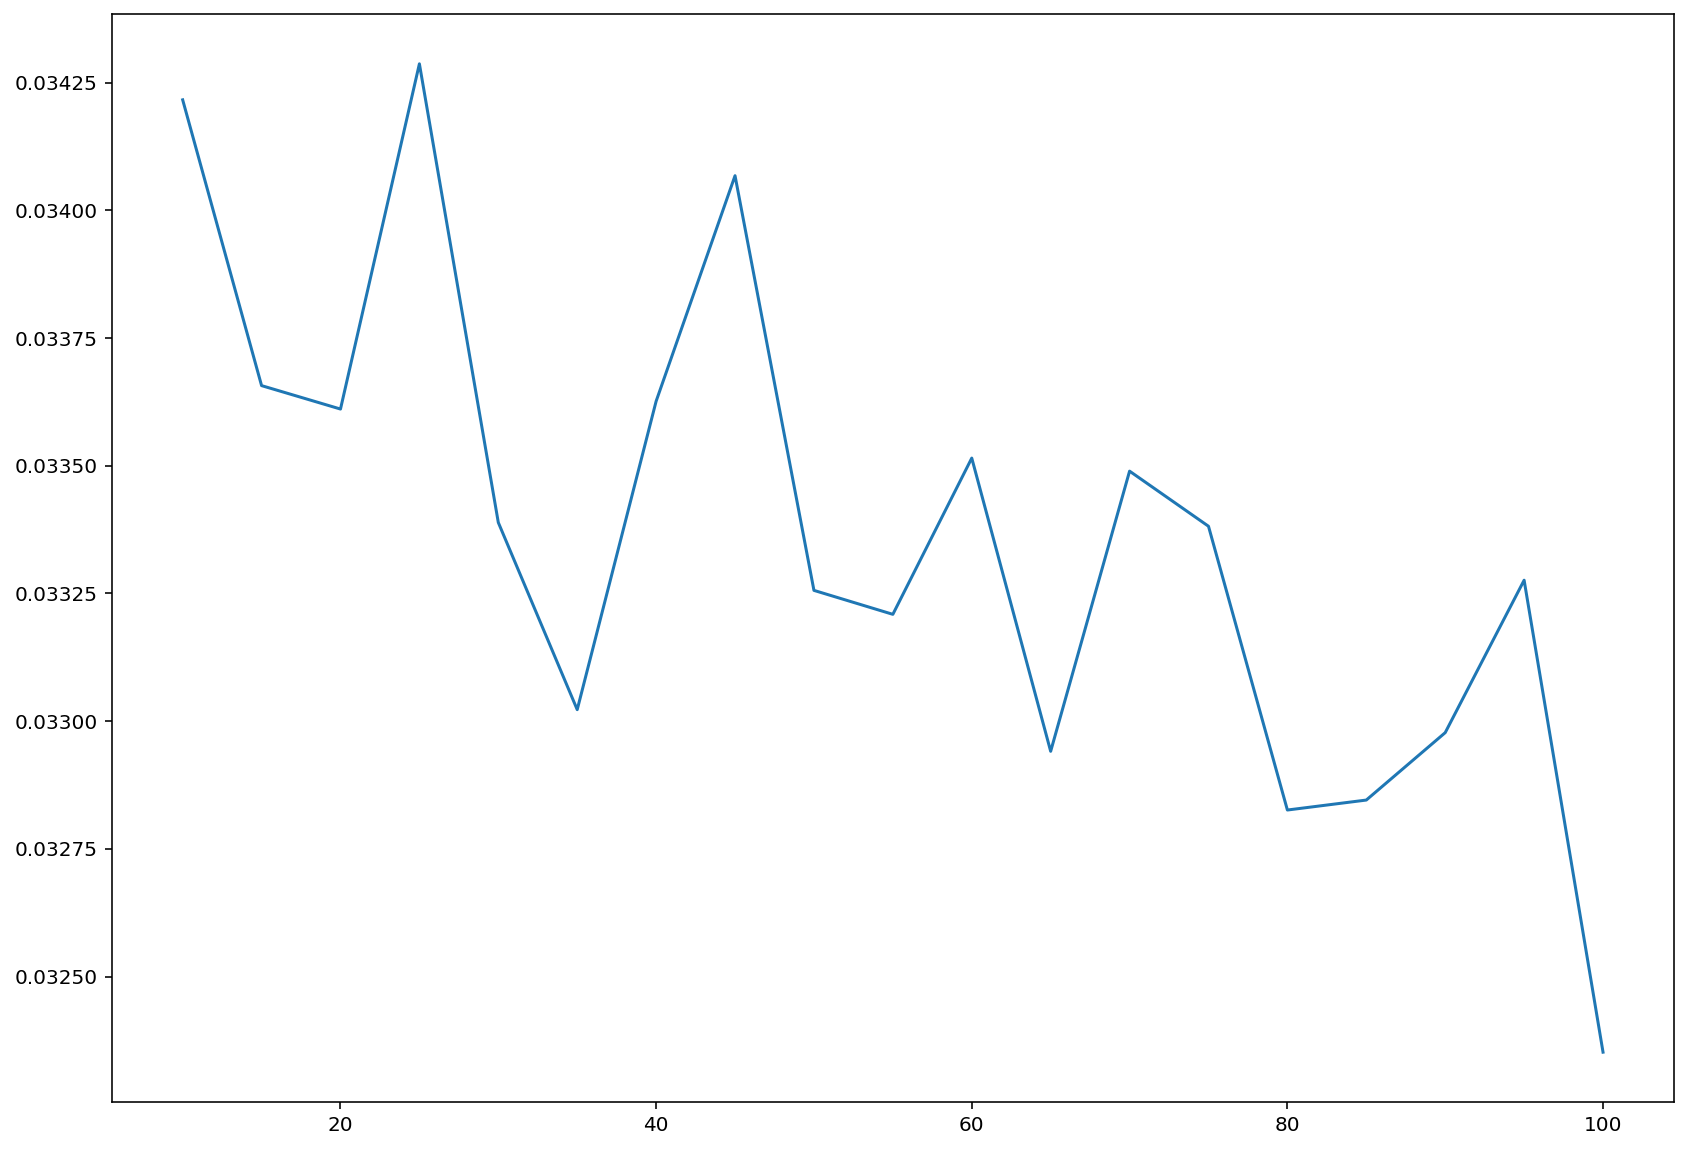

In [ ]:
plt.plot(list(range(10, 101, 5)), lANN)

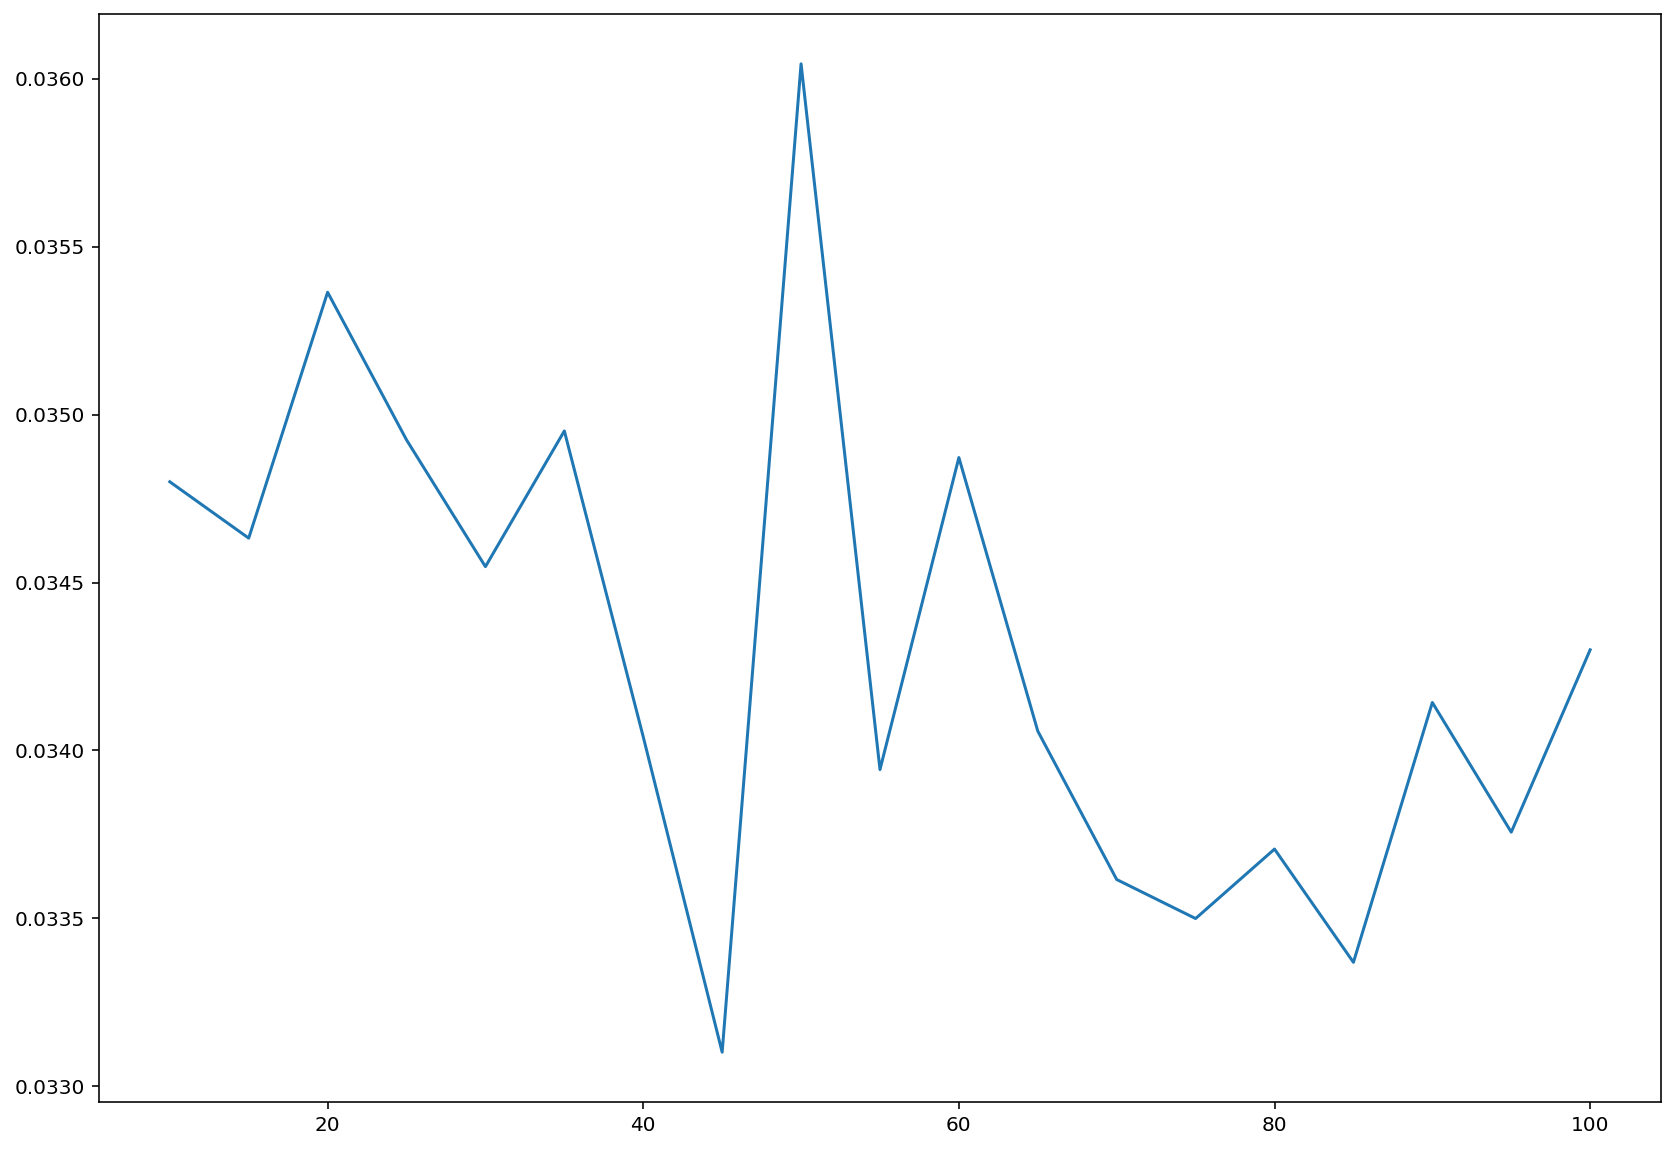

In [ ]:
plt.plot(list(range(10, 101, 5)), lRNN)

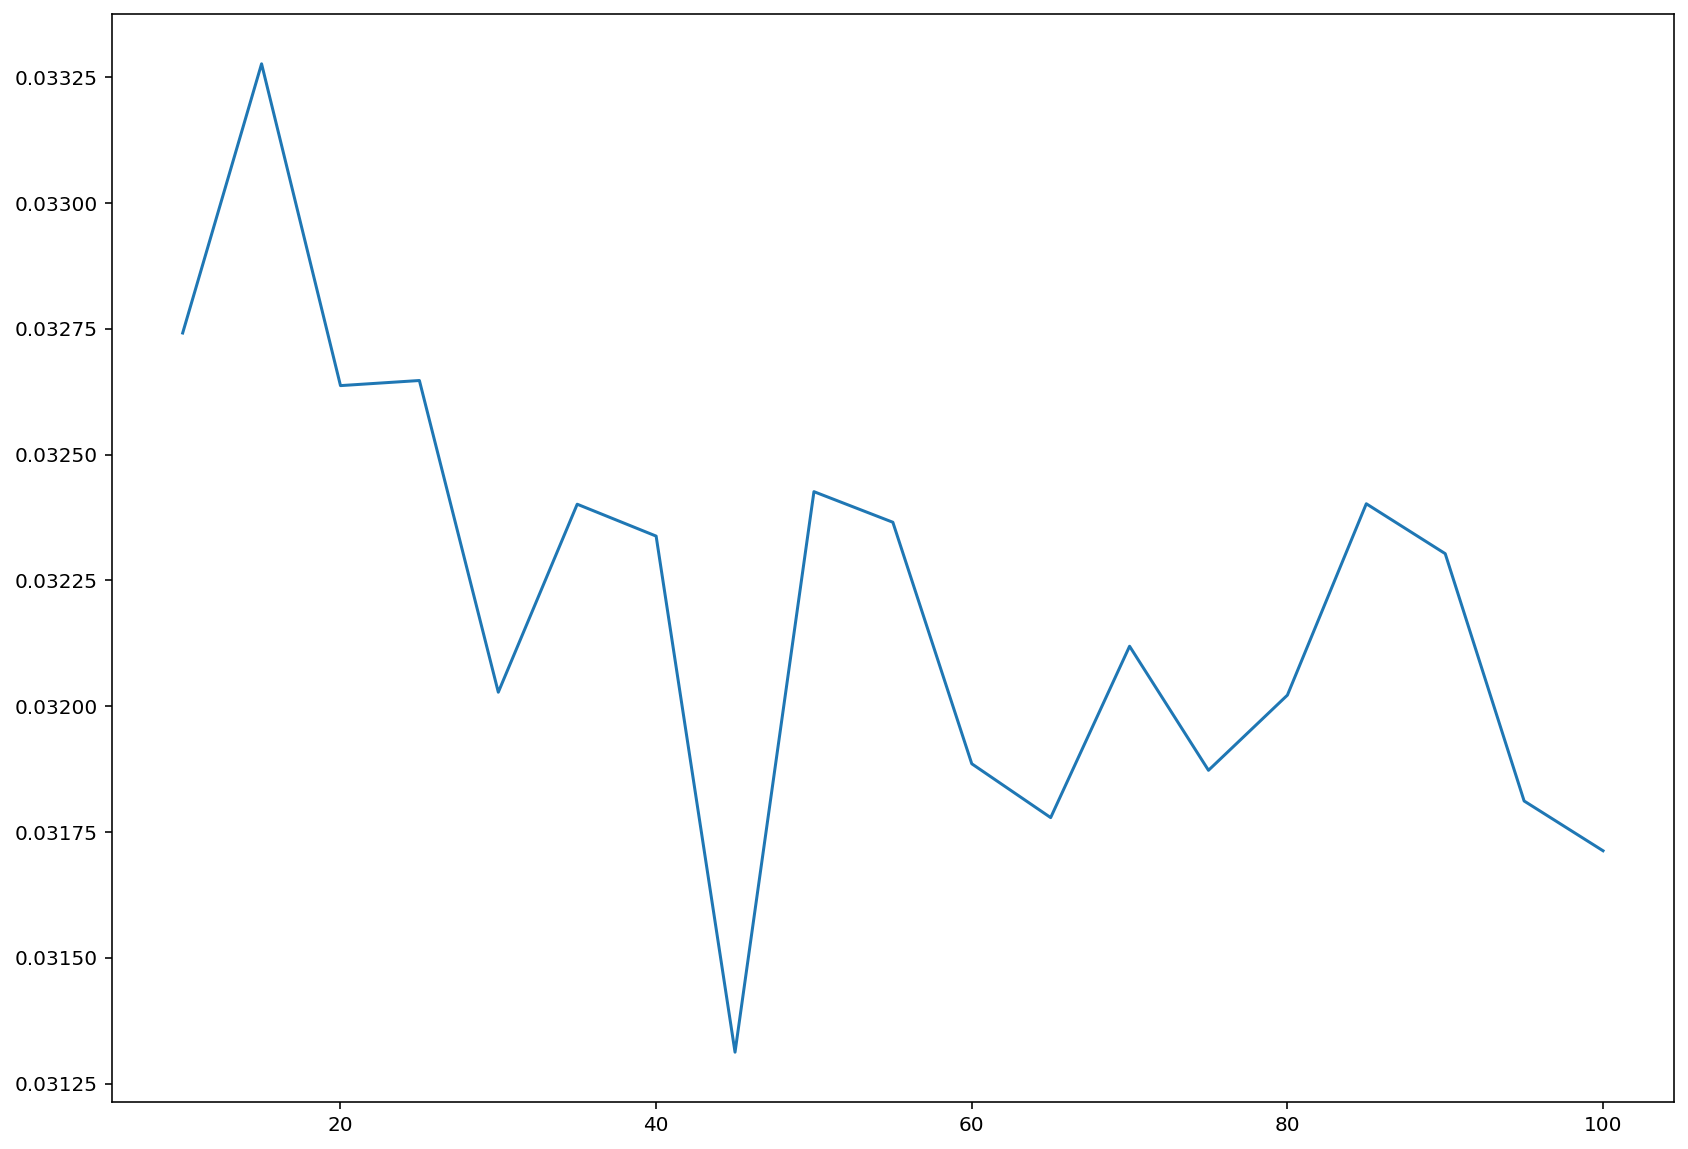

In [ ]:
plt.plot(list(range(10, 101, 5)), lGRU)

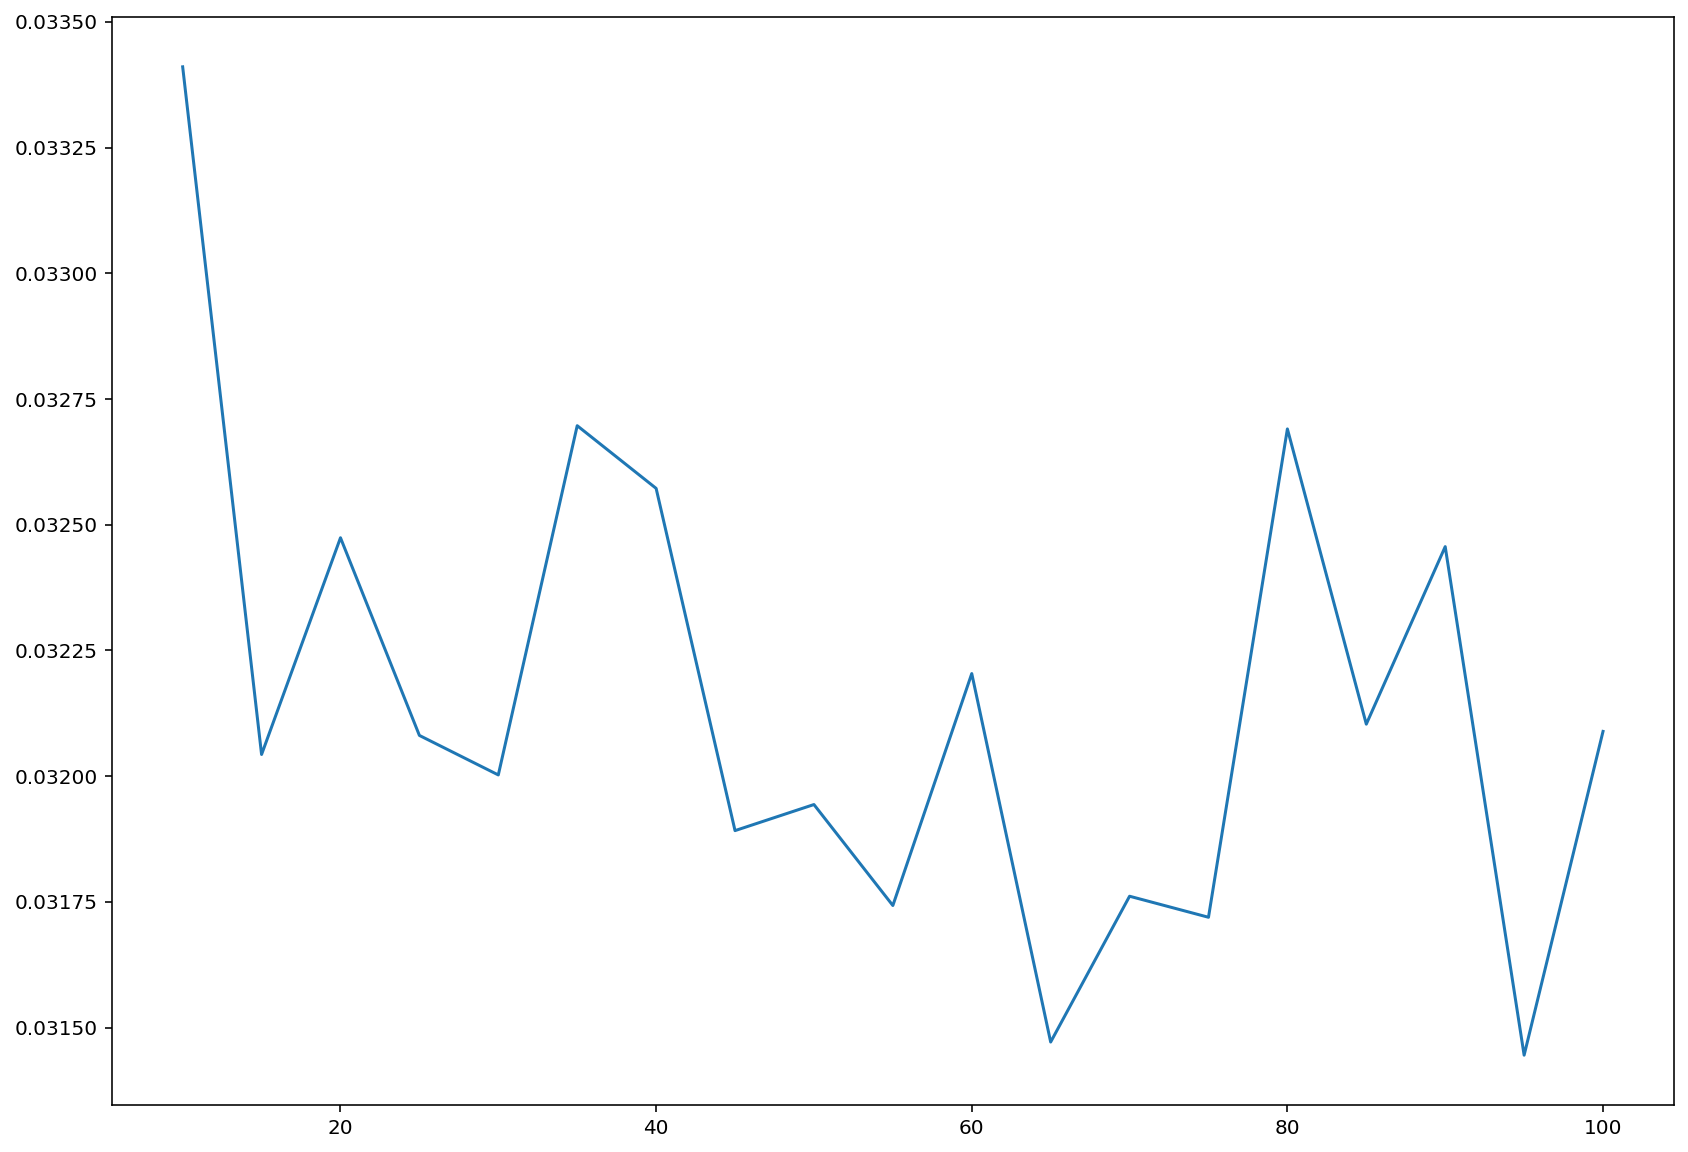

In [ ]:
plt.plot(list(range(10, 101, 5)), lLSTM)

# EOP

In [ ]:
data = pd.read_csv("drive/MyDrive/SSA/month_data.csv", sep = ";")
SIZE = len(data)
data.head()

,Year,Month,x_pole,y_pole,LOD
0,1962,1,-0.044944,0.225739,0.001229
1,1962,2,-0.050477,0.244412,0.001359
2,1962,3,0.004930,0.258291,0.001503
3,1962,4,0.065315,0.234968,0.001664
4,1962,5,0.093417,0.198508,0.001639


## X_POLE

In [ ]:
#ts_x = np.array(data.x_pole)
ts_x = np.array(pd.read_csv("drive/MyDrive/SSA/x_no_trend.csv", sep = ",")['ts_x'])
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 500, 109, 108;
seq_len = 36;

assert TRAIN_SIZE + VAL_SIZE + TEST_SIZE == SIZE, "wrong TRAIN and VAL sizes"

ssa_xpole = edict({
    'L' : TRAIN_SIZE//2,
    'ssa_groups' : list(range(1,29)),
    'rssa' : rssa
})

data_xpole = splitData(ts_x, seq_len, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa_xpole, val_ssa = True)

100%|██████████| 108/108 [00:24<00:00,  4.39it/s]


### SKORCH

In [ ]:
train_ds = Dataset(data_xpole.train.X, data_xpole.train.y.reshape(-1, 1))

valid_ds = Dataset(data_xpole.val.X, data_xpole.val.y.reshape(-1, 1))
valid_ds_ssa = Dataset(data_xpole.val.X_ssa, data_xpole.val.y.reshape(-1, 1))

### Fully Connected

In [ ]:
fcnet = NeuralNetRegressor(  FCModel
                         , module__inputSize=seq_len
                         , module__hiddenLayer=50
                         , module__outputSize=1
                           
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience = 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

fcnet_ssa = NeuralNetRegressor(  FCModel
                         , module__inputSize=seq_len
                         , module__hiddenLayer=50
                         , module__outputSize=1       
                        
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet.fit(data_xpole.train.X, data_xpole.train.y.reshape(-1, 1));
fcnet.history[-1]

{'batches': [{'train_batch_size': 464, 'train_loss': 0.0023811813443899155},
  {'valid_batch_size': 73, 'valid_loss': 0.006959104910492897}],
 'dur': 0.007598400115966797,
 'epoch': 1826,
 'train_batch_count': 1,
 'train_loss': 0.0023811813443899155,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.006959104910492897,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet_ssa.fit(data_xpole.train.X_ssa, data_xpole.train.y.reshape(-1, 1));
fcnet_ssa.history[-1]

{'batches': [{'train_batch_size': 464, 'train_loss': 0.0031900678295642138},
  {'valid_batch_size': 73, 'valid_loss': 0.014727236703038216}],
 'dur': 0.0075566768646240234,
 'epoch': 1887,
 'train_batch_count': 1,
 'train_loss': 0.0031900678295642138,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.014727236703038216,
 'valid_loss_best': False}

### RNN

In [ ]:
rnnnet = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

rnnnet_ssa = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet.fit(data_xpole.train.X, data_xpole.train.y.reshape(-1, 1));
rnnnet.history[-1]

{'batches': [{'train_batch_size': 464, 'train_loss': 0.008627615869045258},
  {'valid_batch_size': 73, 'valid_loss': 0.008275371976196766}],
 'dur': 0.01407313346862793,
 'epoch': 765,
 'train_batch_count': 1,
 'train_loss': 0.008627615869045258,
 'train_loss_best': False,
 'valid_batch_count': 1,
 'valid_loss': 0.008275371976196766,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet_ssa.fit(data_xpole.train.X_ssa, data_xpole.train.y.reshape(-1, 1));
rnnnet_ssa.history[-1]

{'batches': [{'train_batch_size': 464, 'train_loss': 0.009011260233819485},
  {'valid_batch_size': 73, 'valid_loss': 0.01796112395823002}],
 'dur': 0.013368606567382812,
 'epoch': 470,
 'train_batch_count': 1,
 'train_loss': 0.009011260233819485,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.01796112395823002,
 'valid_loss_best': False}

### GRU

In [ ]:
grunet = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

grunet_ssa = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet.fit(data_xpole.train.X, data_xpole.train.y.reshape(-1, 1));
grunet.history[-1]

{'batches': [{'train_batch_size': 464, 'train_loss': 0.004549730569124222},
  {'valid_batch_size': 73, 'valid_loss': 0.007796714548021555}],
 'dur': 0.015597820281982422,
 'epoch': 2383,
 'train_batch_count': 1,
 'train_loss': 0.004549730569124222,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.007796714548021555,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet_ssa.fit(data_xpole.train.X_ssa, data_xpole.train.y.reshape(-1, 1));
grunet_ssa.history[-1]

{'batches': [{'train_batch_size': 464, 'train_loss': 0.00944311823695898},
  {'valid_batch_size': 73, 'valid_loss': 0.021529581397771835}],
 'dur': 0.015157222747802734,
 'epoch': 1055,
 'train_batch_count': 1,
 'train_loss': 0.00944311823695898,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.021529581397771835,
 'valid_loss_best': False}

### LSTM

In [ ]:
lstmnet = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

lstmnet_ssa = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                        # , module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet.fit(data_xpole.train.X, data_xpole.train.y.reshape(-1, 1));
lstmnet.history[-1]

{'batches': [{'train_batch_size': 464, 'train_loss': 0.01837810128927231},
  {'valid_batch_size': 73, 'valid_loss': 0.038312528282403946}],
 'dur': 0.01492929458618164,
 'epoch': 389,
 'train_batch_count': 1,
 'train_loss': 0.01837810128927231,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.038312528282403946,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet_ssa.fit(data_xpole.train.X_ssa, data_xpole.train.y.reshape(-1, 1));
lstmnet_ssa.history[-1]

{'batches': [{'train_batch_size': 464, 'train_loss': 0.024569742381572723},
  {'valid_batch_size': 73, 'valid_loss': 0.061708539724349976}],
 'dur': 0.014352083206176758,
 'epoch': 355,
 'train_batch_count': 1,
 'train_loss': 0.024569742381572723,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.061708539724349976,
 'valid_loss_best': False}

### Results

In [ ]:
pc_ann =  getPredCases(fcnet.module_.to('cpu'), data_xpole, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_ann =  getPredCases(fcnet_ssa.module_.to('cpu'), data_xpole, tomorrow = True, y_ssa=False, ssa = ssa_xpole)
#====================
pc_rnn =  getPredCases(rnnnet.module_.to('cpu'), data_xpole, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_rnn =  getPredCases(rnnnet_ssa.module_.to('cpu'), data_xpole, tomorrow = True, y_ssa=False, ssa = ssa_xpole)
#====================
pc_gru =  getPredCases(grunet.module_.to('cpu'), data_xpole, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_gru =  getPredCases(grunet_ssa.module_.to('cpu'), data_xpole, tomorrow = True, y_ssa=False, ssa = ssa_xpole)
#====================
pc_lstm =  getPredCases(lstmnet.module_.to('cpu'), data_xpole, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_lstm =  getPredCases(lstmnet_ssa.module_.to('cpu'), data_xpole, tomorrow = True, y_ssa=False, ssa = ssa_xpole)

100%|██████████| 108/108 [00:00<00:00, 387.65it/s]


In [ ]:
errs = {'ANN' : getRMSE(ts_x[-TEST_SIZE:], pc_ann)
        , 'SSA-ANN' : getRMSE(ts_x[-TEST_SIZE:], pc_ssa_ann)
        , 'RNN' : getRMSE(ts_x[-TEST_SIZE:], pc_rnn)
        , 'SSA-RNN' : getRMSE(ts_x[-TEST_SIZE:], pc_ssa_rnn)
        , 'GRU' : getRMSE(ts_x[-TEST_SIZE:], pc_gru)
        , 'SSA-GRU' : getRMSE(ts_x[-TEST_SIZE:], pc_ssa_gru)
        , 'LSTM' : getRMSE(ts_x[-TEST_SIZE:], pc_lstm)
        , 'SSA-LSTM' : getRMSE(ts_x[-TEST_SIZE:], pc_ssa_lstm)
        }
pd.DataFrame().from_dict(errs, orient='index').T

,ANN,SSA-ANN,RNN,SSA-RNN,GRU,SSA-GRU,LSTM,SSA-LSTM
0,0.009796,0.021877,0.010755,0.02239,0.010313,0.023937,0.026634,0.02664


> r = 7
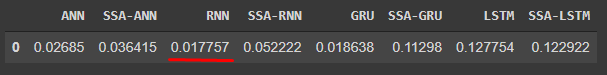

> r = 23 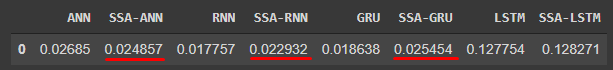

> r = 50 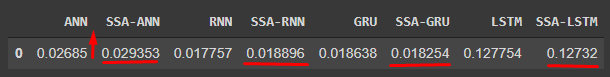



In [ ]:
getStat([pc_ann, pc_ssa_ann, pc_rnn, pc_ssa_rnn, pc_gru, pc_ssa_gru, pc_lstm, pc_ssa_lstm], ts_x[-TEST_SIZE:])

,0,1,2,3,4,5,6,7
0,0.000000e+00,9.984773e-13,2.244323e-13,2.148942e-14,3.182611e-12,6.406357e-15,3.467227e-17,4.178209e-17
1,9.984773e-13,0.000000e+00,1.502317e-11,1.510927e-11,1.585566e-12,3.322905e-14,2.166531e-13,1.539312e-14
2,2.244323e-13,1.502317e-11,0.000000e+00,2.989791e-11,2.658167e-17,4.643764e-16,5.589319e-16,1.564644e-18
3,2.148942e-14,1.510927e-11,2.989791e-11,0.000000e+00,1.181220e-15,4.397037e-17,3.596252e-16,6.096744e-19
4,3.182611e-12,1.585566e-12,2.658167e-17,1.181220e-15,0.000000e+00,2.338149e-13,1.252222e-13,6.312492e-16
5,6.406357e-15,3.322905e-14,4.643764e-16,4.397037e-17,2.338149e-13,0.000000e+00,1.441478e-12,7.065801e-17
6,3.467227e-17,2.166531e-13,5.589319e-16,3.596252e-16,1.252222e-13,1.441478e-12,0.000000e+00,1.101871e-11
7,4.178209e-17,1.539312e-14,1.564644e-18,6.096744e-19,6.312492e-16,7.065801e-17,1.101871e-11,0.000000e+00


In [ ]:
0.000347375044

0.000347375044

## Y_POLE

In [ ]:
#ts_y = np.array(data.y_pole)[::-1]
ts_y = np.array(pd.read_csv("drive/MyDrive/SSA/y_no_trend.csv", sep = ",")['ts_y'])
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 500, 109, 108;
seq_len = 12;

assert TRAIN_SIZE + VAL_SIZE + TEST_SIZE == SIZE, "wrong TRAIN and VAL sizes"

ssa_ypole = edict({
    'L' : TRAIN_SIZE//2,
    'ssa_groups' : list(range(1,24)),
    'rssa' : rssa
})

data_ypole = splitData(ts_y, seq_len, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa_ypole, val_ssa = True)

100%|██████████| 108/108 [00:22<00:00,  4.70it/s]


### SKORCH

In [ ]:
train_ds = Dataset(data_ypole.train.X, data_ypole.train.y.reshape(-1, 1))

valid_ds = Dataset(data_ypole.val.X, data_ypole.val.y.reshape(-1, 1))
valid_ds_ssa = Dataset(data_ypole.val.X_ssa, data_ypole.val.y.reshape(-1, 1))

### Fully Connected

In [ ]:
fcnet = NeuralNetRegressor(  FCModel
                         , module__inputSize=12
                         , module__hiddenLayer=50
                         , module__outputSize=1
                           
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience = 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

fcnet_ssa = NeuralNetRegressor(  FCModel
                         , module__inputSize=12
                         , module__hiddenLayer=50
                         , module__outputSize=1       
                        
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet.fit(data_ypole.train.X, data_ypole.train.y.reshape(-1, 1));
fcnet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.05197548866271973},
  {'valid_batch_size': 97, 'valid_loss': 0.07427354156970978}],
 'dur': 0.008229494094848633,
 'epoch': 108,
 'train_batch_count': 1,
 'train_loss': 0.05197548866271973,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.07427354156970978,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet_ssa.fit(data_ypole.train.X_ssa, data_ypole.train.y.reshape(-1, 1));
fcnet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.053275782614946365},
  {'valid_batch_size': 97, 'valid_loss': 0.12494394928216934}],
 'dur': 0.00822138786315918,
 'epoch': 106,
 'train_batch_count': 1,
 'train_loss': 0.053275782614946365,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.12494394928216934,
 'valid_loss_best': False}

### RNN

In [ ]:
rnnnet = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

rnnnet_ssa = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet.fit(data_ypole.train.X, data_ypole.train.y.reshape(-1, 1));
rnnnet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.022036423906683922},
  {'valid_batch_size': 97, 'valid_loss': 0.027122851461172104}],
 'dur': 0.009392738342285156,
 'epoch': 192,
 'train_batch_count': 1,
 'train_loss': 0.022036423906683922,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.027122851461172104,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet_ssa.fit(data_ypole.train.X_ssa, data_ypole.train.y.reshape(-1, 1));
rnnnet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.0071416799910366535},
  {'valid_batch_size': 97, 'valid_loss': 0.008991891518235207}],
 'dur': 0.00996541976928711,
 'epoch': 500,
 'train_batch_count': 1,
 'train_loss': 0.0071416799910366535,
 'train_loss_best': False,
 'valid_batch_count': 1,
 'valid_loss': 0.008991891518235207,
 'valid_loss_best': False}

### GRU

In [ ]:
grunet = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

grunet_ssa = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet.fit(data_ypole.train.X, data_ypole.train.y.reshape(-1, 1));
grunet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.00319917150773108},
  {'valid_batch_size': 97, 'valid_loss': 0.0031759205739945173}],
 'dur': 0.016191959381103516,
 'epoch': 3411,
 'train_batch_count': 1,
 'train_loss': 0.00319917150773108,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.0031759205739945173,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet_ssa.fit(data_ypole.train.X_ssa, data_ypole.train.y.reshape(-1, 1));
grunet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.007125126197934151},
  {'valid_batch_size': 97, 'valid_loss': 0.006808694917708635}],
 'dur': 0.010132551193237305,
 'epoch': 1262,
 'train_batch_count': 1,
 'train_loss': 0.007125126197934151,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.006808694917708635,
 'valid_loss_best': False}

### LSTM

In [ ]:
lstmnet = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

lstmnet_ssa = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                        # , module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet.fit(data_ypole.train.X, data_ypole.train.y.reshape(-1, 1));
lstmnet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.003140342654660344},
  {'valid_batch_size': 97, 'valid_loss': 0.0030203319620341063}],
 'dur': 0.010876178741455078,
 'epoch': 4853,
 'train_batch_count': 1,
 'train_loss': 0.003140342654660344,
 'train_loss_best': False,
 'valid_batch_count': 1,
 'valid_loss': 0.0030203319620341063,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet_ssa.fit(data_ypole.train.X_ssa, data_ypole.train.y.reshape(-1, 1));
lstmnet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.007016412448137999},
  {'valid_batch_size': 97, 'valid_loss': 0.0413714237511158}],
 'dur': 0.009901285171508789,
 'epoch': 1070,
 'train_batch_count': 1,
 'train_loss': 0.007016412448137999,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.0413714237511158,
 'valid_loss_best': False}

### Results

In [ ]:
pc_ann =  getPredCases(fcnet.module_.to('cpu'), data_ypole, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_ann =  getPredCases(fcnet_ssa.module_.to('cpu'), data_ypole, tomorrow = True, y_ssa=False, ssa = ssa_ypole)
#====================
pc_rnn =  getPredCases(rnnnet.module_.to('cpu'), data_ypole, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_rnn =  getPredCases(rnnnet_ssa.module_.to('cpu'), data_ypole, tomorrow = True, y_ssa=False, ssa = ssa_ypole)
#====================
pc_gru =  getPredCases(grunet.module_.to('cpu'), data_ypole, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_gru =  getPredCases(grunet_ssa.module_.to('cpu'), data_ypole, tomorrow = True, y_ssa=False, ssa = ssa_ypole)
#====================
pc_lstm =  getPredCases(lstmnet.module_.to('cpu'), data_ypole, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_lstm =  getPredCases(lstmnet_ssa.module_.to('cpu'), data_ypole, tomorrow = True, y_ssa=False, ssa = ssa_ypole)

100%|██████████| 108/108 [00:00<00:00, 850.07it/s]


In [ ]:
errs = {'ANN' : getRMSE(ts_y[-TEST_SIZE:], pc_ann)
        , 'SSA-ANN' : getRMSE(ts_y[-TEST_SIZE:], pc_ssa_ann)
        , 'RNN' : getRMSE(ts_y[-TEST_SIZE:], pc_rnn)
        , 'SSA-RNN' : getRMSE(ts_y[-TEST_SIZE:], pc_ssa_rnn)
        , 'GRU' : getRMSE(ts_y[-TEST_SIZE:], pc_gru)
        , 'SSA-GRU' : getRMSE(ts_y[-TEST_SIZE:], pc_ssa_gru)
        , 'LSTM' : getRMSE(ts_y[-TEST_SIZE:], pc_lstm)
        , 'SSA-LSTM' : getRMSE(ts_y[-TEST_SIZE:], pc_ssa_lstm)
        }
pd.DataFrame().from_dict(errs, orient='index').T

,ANN,SSA-ANN,RNN,SSA-RNN,GRU,SSA-GRU,LSTM,SSA-LSTM
0,0.030852,0.03417,0.017784,0.017417,0.008546,0.016408,0.007965,0.02024


> r = 7 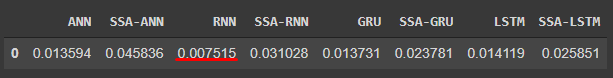

> r = 23 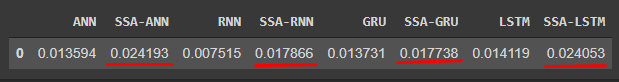

> r = 50 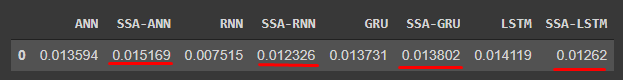

In [ ]:
0.000093161104

9.3161104e-05

## LOD

In [ ]:
ts_LOD = np.array(data.LOD)
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 500, 109, 108;
seq_len = 12;

assert TRAIN_SIZE + VAL_SIZE + TEST_SIZE == SIZE, "wrong TRAIN and VAL sizes"

ssa_LOD = edict({
    'L' : TRAIN_SIZE//2,
    'ssa_groups' : list(range(1,29)),
    'rssa' : rssa
})

data_LOD = splitData(ts_LOD, seq_len, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa_LOD, val_ssa = True)

100%|██████████| 108/108 [00:24<00:00,  4.46it/s]


### SKORCH

In [ ]:
train_ds = Dataset(data_LOD.train.X, data_LOD.train.y.reshape(-1, 1))

valid_ds = Dataset(data_LOD.val.X, data_LOD.val.y.reshape(-1, 1))
valid_ds_ssa = Dataset(data_LOD.val.X_ssa, data_LOD.val.y.reshape(-1, 1))

### Fully Connected

In [ ]:
fcnet = NeuralNetRegressor(  FCModel
                         , module__inputSize=12
                         , module__hiddenLayer=50
                         , module__outputSize=1
                           
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience = 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

fcnet_ssa = NeuralNetRegressor(  FCModel
                         , module__inputSize=12
                         , module__hiddenLayer=50
                         , module__outputSize=1       
                        
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet.fit(data_LOD.train.X, data_LOD.train.y.reshape(-1, 1));
fcnet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.03509680926799774},
  {'valid_batch_size': 97, 'valid_loss': 0.046080656349658966}],
 'dur': 0.007677793502807617,
 'epoch': 876,
 'train_batch_count': 1,
 'train_loss': 0.03509680926799774,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.046080656349658966,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet_ssa.fit(data_LOD.train.X_ssa, data_LOD.train.y.reshape(-1, 1));
fcnet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.02289324812591076},
  {'valid_batch_size': 97, 'valid_loss': 0.03671436384320259}],
 'dur': 0.008488655090332031,
 'epoch': 600,
 'train_batch_count': 1,
 'train_loss': 0.02289324812591076,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.03671436384320259,
 'valid_loss_best': False}

### RNN

In [ ]:
rnnnet = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

rnnnet_ssa = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet.fit(data_LOD.train.X, data_LOD.train.y.reshape(-1, 1));
rnnnet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.07333986461162567},
  {'valid_batch_size': 97, 'valid_loss': 0.0842060074210167}],
 'dur': 0.010556936264038086,
 'epoch': 422,
 'train_batch_count': 1,
 'train_loss': 0.07333986461162567,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.0842060074210167,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet_ssa.fit(data_LOD.train.X_ssa, data_LOD.train.y.reshape(-1, 1));
rnnnet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.04024979844689369},
  {'valid_batch_size': 97, 'valid_loss': 0.05528062954545021}],
 'dur': 0.009513616561889648,
 'epoch': 662,
 'train_batch_count': 1,
 'train_loss': 0.04024979844689369,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.05528062954545021,
 'valid_loss_best': False}

### GRU

In [ ]:
grunet = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

grunet_ssa = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet.fit(data_LOD.train.X, data_LOD.train.y.reshape(-1, 1));
grunet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.1334223449230194},
  {'valid_batch_size': 97, 'valid_loss': 0.2172834724187851}],
 'dur': 0.009918451309204102,
 'epoch': 395,
 'train_batch_count': 1,
 'train_loss': 0.1334223449230194,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.2172834724187851,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet_ssa.fit(data_LOD.train.X_ssa, data_LOD.train.y.reshape(-1, 1));
grunet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.12469540536403656},
  {'valid_batch_size': 97, 'valid_loss': 0.20445504784584045}],
 'dur': 0.010083675384521484,
 'epoch': 403,
 'train_batch_count': 1,
 'train_loss': 0.12469540536403656,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.20445504784584045,
 'valid_loss_best': False}

### LSTM

In [ ]:
lstmnet = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

lstmnet_ssa = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                        # , module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet.fit(data_LOD.train.X, data_LOD.train.y.reshape(-1, 1));
lstmnet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.2475397288799286},
  {'valid_batch_size': 97, 'valid_loss': 0.2366761565208435}],
 'dur': 0.010988473892211914,
 'epoch': 139,
 'train_batch_count': 1,
 'train_loss': 0.2475397288799286,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.2366761565208435,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet_ssa.fit(data_LOD.train.X_ssa, data_LOD.train.y.reshape(-1, 1));
lstmnet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.23478133976459503},
  {'valid_batch_size': 97, 'valid_loss': 0.2300971895456314}],
 'dur': 0.016509532928466797,
 'epoch': 155,
 'train_batch_count': 1,
 'train_loss': 0.23478133976459503,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.2300971895456314,
 'valid_loss_best': False}

### Results

In [ ]:
pc_ann =  getPredCases(fcnet.module_.to('cpu'), data_LOD, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_ann =  getPredCases(fcnet_ssa.module_.to('cpu'), data_LOD, tomorrow = True, y_ssa=False, ssa = ssa_LOD)
#====================
pc_rnn =  getPredCases(rnnnet.module_.to('cpu'), data_LOD, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_rnn =  getPredCases(rnnnet_ssa.module_.to('cpu'), data_LOD, tomorrow = True, y_ssa=False, ssa = ssa_LOD)
#====================
pc_gru =  getPredCases(grunet.module_.to('cpu'), data_LOD, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_gru =  getPredCases(grunet_ssa.module_.to('cpu'), data_LOD, tomorrow = True, y_ssa=False, ssa = ssa_LOD)
#====================
pc_lstm =  getPredCases(lstmnet.module_.to('cpu'), data_LOD, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_lstm =  getPredCases(lstmnet_ssa.module_.to('cpu'), data_LOD, tomorrow = True, y_ssa=False, ssa = ssa_LOD)

100%|██████████| 108/108 [00:00<00:00, 869.93it/s]


In [ ]:
errs = {'ANN' : getRMSE(ts_LOD[-TEST_SIZE:], pc_ann)
        , 'SSA-ANN' : getRMSE(ts_LOD[-TEST_SIZE:], pc_ssa_ann)
        , 'RNN' : getRMSE(ts_LOD[-TEST_SIZE:], pc_rnn)
        , 'SSA-RNN' : getRMSE(ts_LOD[-TEST_SIZE:], pc_ssa_rnn)
        , 'GRU' : getRMSE(ts_LOD[-TEST_SIZE:], pc_gru)
        , 'SSA-GRU' : getRMSE(ts_LOD[-TEST_SIZE:], pc_ssa_gru)
        , 'LSTM' : getRMSE(ts_LOD[-TEST_SIZE:], pc_lstm)
        , 'SSA-LSTM' : getRMSE(ts_LOD[-TEST_SIZE:], pc_ssa_lstm)
        }
pd.DataFrame().from_dict(errs, orient='index').T

,ANN,SSA-ANN,RNN,SSA-RNN,GRU,SSA-GRU,LSTM,SSA-LSTM
0,0.000163,0.000191,0.000209,0.000212,0.000524,0.000527,0.000532,0.000516


In [ ]:
0.000000026569

2.6569e-08

# Double sine wave

## Data 

$ x_i = \sin(2 \pi \frac{i}{T}) + 1.6 \sin(2 \pi \frac{i}{T+2}) + 𝛆_i, \; i = [1, \cdots, 700] $ 

In [ ]:
ts_dsw = ts_y = np.array(pd.read_csv("drive/MyDrive/SSA/model_double_sine_cos_0.3noise.csv", sep = ",")['x'])

SIZE = len(ts_dsw)

TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 500, 100, 100;
seq_len = 12;

assert TRAIN_SIZE + VAL_SIZE + TEST_SIZE == SIZE, "wrong TRAIN and VAL sizes"

ssa_dsw = edict({
    'L' : TRAIN_SIZE//2,
    'ssa_groups' : list(range(1,9)),
    'rssa' : rssa
})

data_dsw = splitData(ts_dsw, seq_len, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa_dsw, val_ssa = True)

100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


In [ ]:
train_ds = Dataset(data_dsw.train.X, data_dsw.train.y.reshape(-1, 1))

valid_ds = Dataset(data_dsw.val.X, data_dsw.val.y.reshape(-1, 1))
valid_ds_ssa = Dataset(data_dsw.val.X_ssa, data_dsw.val.y.reshape(-1, 1))

## Fully Connected

In [ ]:
fcnet = NeuralNetRegressor(  FCModel
                         , module__inputSize=12
                         , module__hiddenLayer=50
                         , module__outputSize=1
                           
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience = 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

fcnet_ssa = NeuralNetRegressor(  FCModel
                         , module__inputSize=12
                         , module__hiddenLayer=50
                         , module__outputSize=1       
                        
                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet.fit(data_dsw.train.X, data_dsw.train.y.reshape(-1, 1));
fcnet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.08622819185256958},
  {'valid_batch_size': 88, 'valid_loss': 0.10993615537881851}],
 'dur': 0.008054018020629883,
 'epoch': 438,
 'train_batch_count': 1,
 'train_loss': 0.08622819185256958,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.10993615537881851,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
fcnet_ssa.fit(data_dsw.train.X_ssa, data_dsw.train.y.reshape(-1, 1));
fcnet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.05792940780520439},
  {'valid_batch_size': 88, 'valid_loss': 0.09095246344804764}],
 'dur': 0.0072972774505615234,
 'epoch': 767,
 'train_batch_count': 1,
 'train_loss': 0.05792940780520439,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.09095246344804764,
 'valid_loss_best': False}

## RNN

In [ ]:
rnnnet = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

rnnnet_ssa = NeuralNetRegressor(  RNN
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet.fit(data_dsw.train.X, data_dsw.train.y.reshape(-1, 1));
rnnnet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.09252269566059113},
  {'valid_batch_size': 88, 'valid_loss': 0.11174535751342773}],
 'dur': 0.009384870529174805,
 'epoch': 588,
 'train_batch_count': 1,
 'train_loss': 0.09252269566059113,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.11174535751342773,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
rnnnet_ssa.fit(data_dsw.train.X_ssa, data_dsw.train.y.reshape(-1, 1));
rnnnet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.07348678261041641},
  {'valid_batch_size': 88, 'valid_loss': 0.1396562159061432}],
 'dur': 0.010039567947387695,
 'epoch': 180,
 'train_batch_count': 1,
 'train_loss': 0.07348678261041641,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.1396562159061432,
 'valid_loss_best': False}

## GRU

In [ ]:
grunet = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

grunet_ssa = NeuralNetRegressor(  GRU
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet.fit(data_dsw.train.X, data_dsw.train.y.reshape(-1, 1));
grunet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.07872223109006882},
  {'valid_batch_size': 88, 'valid_loss': 0.11519406735897064}],
 'dur': 0.00977015495300293,
 'epoch': 1090,
 'train_batch_count': 1,
 'train_loss': 0.07872223109006882,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.11519406735897064,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
grunet_ssa.fit(data_dsw.train.X_ssa, data_dsw.train.y.reshape(-1, 1));
grunet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.06384292989969254},
  {'valid_batch_size': 88, 'valid_loss': 0.14194415509700775}],
 'dur': 0.010170936584472656,
 'epoch': 665,
 'train_batch_count': 1,
 'train_loss': 0.06384292989969254,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.14194415509700775,
 'valid_loss_best': False}

## LSTM

In [ ]:
lstmnet = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                         #, module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

lstmnet_ssa = NeuralNetRegressor(  LSTM
                         , module__input_size = 1
                         , module__hidden_size = 12
                         , module__output_size=1
                        # , module__device = device


                         , callbacks = [
                                      MyEarlyStopping(monitor='valid_loss', patience= 50)
                         ]
                         , train_split= predefined_split(valid_ds_ssa)
                         , max_epochs = 5000
                         , optimizer=torch.optim.Adam
                         , lr=0.001
                         , batch_size = -1
                         , verbose=0
                         , device = device)

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet.fit(data_dsw.train.X, data_dsw.train.y.reshape(-1, 1));
lstmnet.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.07793165743350983},
  {'valid_batch_size': 88, 'valid_loss': 0.11059331893920898}],
 'dur': 0.0192258358001709,
 'epoch': 901,
 'train_batch_count': 1,
 'train_loss': 0.07793165743350983,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.11059331893920898,
 'valid_loss_best': False}

In [ ]:
torch.manual_seed(RANDOM_SEED)
lstmnet_ssa.fit(data_dsw.train.X_ssa, data_dsw.train.y.reshape(-1, 1));
lstmnet_ssa.history[-1]

{'batches': [{'train_batch_size': 488, 'train_loss': 0.05639829486608505},
  {'valid_batch_size': 88, 'valid_loss': 0.10227560251951218}],
 'dur': 0.009755373001098633,
 'epoch': 984,
 'train_batch_count': 1,
 'train_loss': 0.05639829486608505,
 'train_loss_best': True,
 'valid_batch_count': 1,
 'valid_loss': 0.10227560251951218,
 'valid_loss_best': False}

## Results

In [ ]:
pc_ann =  getPredCases(fcnet.module_.to('cpu'), data_dsw, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_ann =  getPredCases(fcnet_ssa.module_.to('cpu'), data_dsw, tomorrow = True, y_ssa=False, ssa = ssa_dsw)
#====================
pc_rnn =  getPredCases(rnnnet.module_.to('cpu'), data_dsw, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_rnn =  getPredCases(rnnnet_ssa.module_.to('cpu'), data_dsw, tomorrow = True, y_ssa=False, ssa = ssa_dsw)
#====================
pc_gru =  getPredCases(grunet.module_.to('cpu'), data_dsw, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_gru =  getPredCases(grunet_ssa.module_.to('cpu'), data_dsw, tomorrow = True, y_ssa=False, ssa = ssa_dsw)
#====================
pc_lstm =  getPredCases(lstmnet.module_.to('cpu'), data_dsw, tomorrow = True, y_ssa=False, ssa = None)
pc_ssa_lstm =  getPredCases(lstmnet_ssa.module_.to('cpu'), data_dsw, tomorrow = True, y_ssa=False, ssa = ssa_dsw)

100%|██████████| 100/100 [00:00<00:00, 707.90it/s]


In [ ]:
errs = {'ANN' : getRMSE(ts_dsw[-TEST_SIZE:], pc_ann)
        , 'SSA-ANN' : getRMSE(ts_dsw[-TEST_SIZE:], pc_ssa_ann)
        , 'RNN' : getRMSE(ts_dsw[-TEST_SIZE:], pc_rnn)
        , 'SSA-RNN' : getRMSE(ts_dsw[-TEST_SIZE:], pc_ssa_rnn)
        , 'GRU' : getRMSE(ts_dsw[-TEST_SIZE:], pc_gru)
        , 'SSA-GRU' : getRMSE(ts_dsw[-TEST_SIZE:], pc_ssa_gru)
        , 'LSTM' : getRMSE(ts_dsw[-TEST_SIZE:], pc_lstm)
        , 'SSA-LSTM' : getRMSE(ts_dsw[-TEST_SIZE:], pc_ssa_lstm)
        }
pd.DataFrame().from_dict(errs, orient='index').T

,ANN,SSA-ANN,RNN,SSA-RNN,GRU,SSA-GRU,LSTM,SSA-LSTM
0,1.886303,1.700304,1.921483,2.049044,1.93252,1.83448,1.874059,1.823168


# Гипотезы

TODO:
1. Построить гипотезы и проверить о том что MSE одинаково. (парный критерий)
2. Подбор параметров
3. SSA r = 50

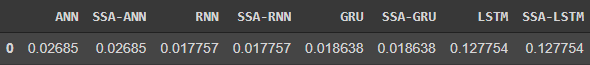

4. RNN & sin & linear & relu

Почему для x и y разные результаты ?

1. Длины окон L и r
2. Перевернуть ряды
3. Убирание тренд (L = 12)
4. Прогноз по точкам: 24, 36, ...

TODO: 

1. Модельный ряд sin T = 12, T = 12.5

# Results

## 1. Длины окон L и r


### X_pole

L = 12, r = 3 

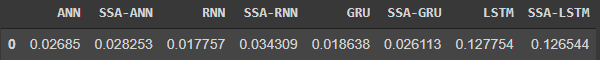

L = 36, r = 5 

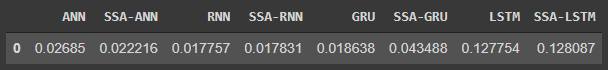

L = 72, r = 5, 22, 28

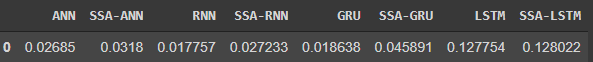

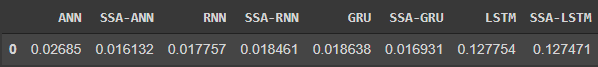

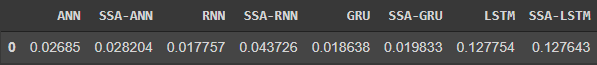

L = 120, r = 10, 26

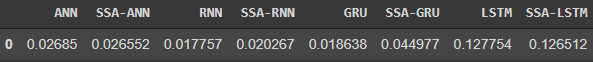

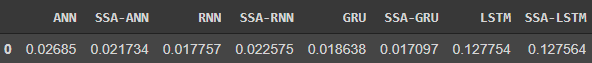

L = 240, r = 21, 27

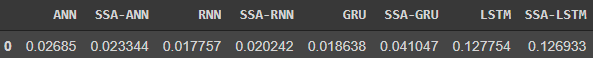

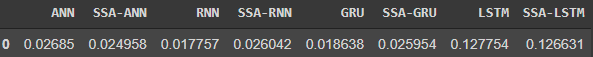


### Y_pole

L = 12, r = 3

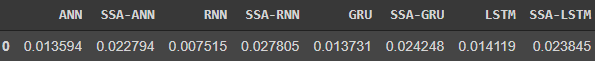

L = 36, r = 7

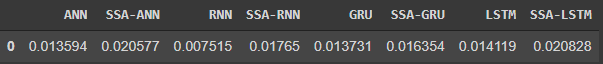

L = 72, r = 10, 17

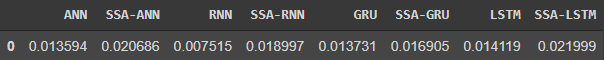

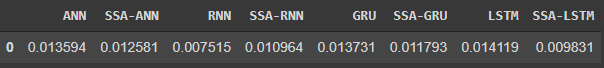


L = 120, r = 29

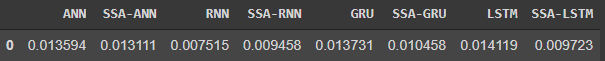


L = 240, r = 18, 33

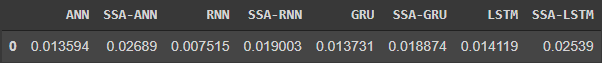

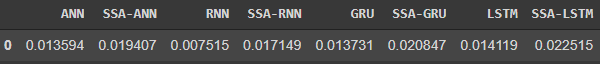

## 2. Перевернутые ряды

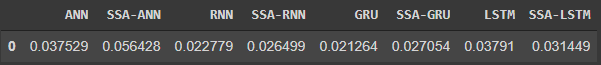

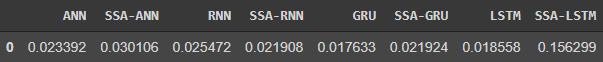

## 3. Без тренда

X_pole:

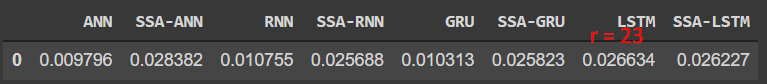

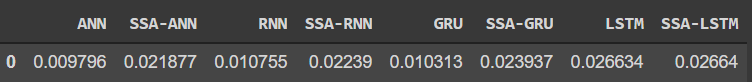

Y_pole:

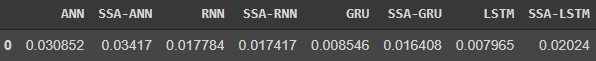

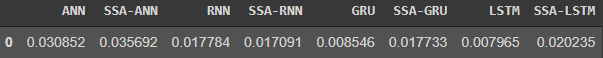